In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 20
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_firstorder_Range_firstorder_Skewness_firstorder_Variance_firstorder_Uniformity_glcm_JointAverage_glcm_ClusterProminence_glcm_ClusterShade_glcm_ClusterTendency_glcm_Contrast_glcm_Correlation_glcm_DifferenceAverage_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_LargeAreaLowGrayLevelEmphasis_glszm_LargeAreaHighGrayLevelEmphasis_glrlm_ShortRunEmphasis_glrlm_LongRunEmphasis_glrlm_GrayLevelNonUniformity_glrlm_GrayLevelNonUniformityNormalized_glrlm_RunLengthNonUniformity_glrlm_Run

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(657450, 648)
(657450, 8)
validation
(74368, 648)
(74368, 8)
test
(91684, 648)
(91684, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 648)]             0         


 dense (Dense)               (None, 1024)              664576    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1354632 (5.17 MB)


Trainable params: 1354632 (5.17 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/66 [..............................] - ETA: 1:45 - loss: 2.6058 - STD: 0.0884 - MAE: 0.2255

 4/66 [>.............................] - ETA: 1s - loss: 1.9152 - STD: 0.0853 - MAE: 0.2009  

 6/66 [=>............................] - ETA: 1s - loss: 1.7331 - STD: 0.1255 - MAE: 0.1807

 8/66 [==>...........................] - ETA: 2s - loss: 1.6555 - STD: 0.1564 - MAE: 0.1668

10/66 [===>..........................] - ETA: 2s - loss: 1.6087 - STD: 0.1762 - MAE: 0.1579

11/66 [====>.........................] - ETA: 7s - loss: 1.5918 - STD: 0.1828 - MAE: 0.1547

14/66 [=====>........................] - ETA: 5s - loss: 1.5402 - STD: 0.1923 - MAE: 0.1499

16/66 [======>.......................] - ETA: 4s - loss: 1.5108 - STD: 0.1926 - MAE: 0.1491

18/66 [=======>......................] - ETA: 4s - loss: 1.4901 - STD: 0.1907 - MAE: 0.1494

20/66 [========>.....................] - ETA: 3s - loss: 1.4760 - STD: 0.1884 - MAE: 0.1501

22/66 [=========>....................] - ETA: 3s - loss: 1.4632 - STD: 0.1867 - MAE: 0.1504

24/66 [=========>....................] - ETA: 3s - loss: 1.4518 - STD: 0.1862 - MAE: 0.1504

26/66 [==========>...................] - ETA: 2s - loss: 1.4405 - STD: 0.1867 - MAE: 0.1499

28/66 [===========>..................] - ETA: 2s - loss: 1.4315 - STD: 0.1879 - MAE: 0.1493

30/66 [============>.................] - ETA: 2s - loss: 1.4244 - STD: 0.1893 - MAE: 0.1486

32/66 [=============>................] - ETA: 2s - loss: 1.4178 - STD: 0.1906 - MAE: 0.1479

34/66 [==============>...............] - ETA: 2s - loss: 1.4118 - STD: 0.1916 - MAE: 0.1474

36/66 [===============>..............] - ETA: 1s - loss: 1.4057 - STD: 0.1920 - MAE: 0.1471

38/66 [================>.............] - ETA: 1s - loss: 1.4006 - STD: 0.1920 - MAE: 0.1470

40/66 [=================>............] - ETA: 1s - loss: 1.3962 - STD: 0.1917 - MAE: 0.1471

42/66 [==================>...........] - ETA: 1s - loss: 1.3921 - STD: 0.1912 - MAE: 0.1471

44/66 [===================>..........] - ETA: 1s - loss: 1.3884 - STD: 0.1908 - MAE: 0.1472

46/66 [===================>..........] - ETA: 1s - loss: 1.3849 - STD: 0.1906 - MAE: 0.1472

48/66 [====================>.........] - ETA: 1s - loss: 1.3820 - STD: 0.1905 - MAE: 0.1472

50/66 [=====================>........] - ETA: 0s - loss: 1.3790 - STD: 0.1906 - MAE: 0.1471

52/66 [======================>.......] - ETA: 0s - loss: 1.3762 - STD: 0.1908 - MAE: 0.1469

54/66 [=======================>......] - ETA: 0s - loss: 1.3733 - STD: 0.1910 - MAE: 0.1468

56/66 [========================>.....] - ETA: 0s - loss: 1.3706 - STD: 0.1912 - MAE: 0.1466

58/66 [=========================>....] - ETA: 0s - loss: 1.3687 - STD: 0.1913 - MAE: 0.1466

60/66 [==========================>...] - ETA: 0s - loss: 1.3663 - STD: 0.1914 - MAE: 0.1465

62/66 [===========================>..] - ETA: 0s - loss: 1.3648 - STD: 0.1914 - MAE: 0.1464

64/66 [============================>.] - ETA: 0s - loss: 1.3625 - STD: 0.1914 - MAE: 0.1464

66/66 [==============================] - ETA: 0s - loss: 1.3607 - STD: 0.1913 - MAE: 0.1464

66/66 [==============================] - 6s 68ms/step - loss: 1.3607 - STD: 0.1913 - MAE: 0.1464 - val_loss: 1.2452 - val_STD: 0.1906 - val_MAE: 0.1424


Epoch 2/10000


 1/66 [..............................] - ETA: 5s - loss: 1.2948 - STD: 0.1906 - MAE: 0.1447

 3/66 [>.............................] - ETA: 2s - loss: 1.3047 - STD: 0.1913 - MAE: 0.1450

 5/66 [=>............................] - ETA: 2s - loss: 1.3023 - STD: 0.1920 - MAE: 0.1446

 7/66 [==>...........................] - ETA: 2s - loss: 1.3013 - STD: 0.1927 - MAE: 0.1443

 9/66 [===>..........................] - ETA: 2s - loss: 1.3045 - STD: 0.1932 - MAE: 0.1443

11/66 [====>.........................] - ETA: 2s - loss: 1.3052 - STD: 0.1934 - MAE: 0.1442

13/66 [====>.........................] - ETA: 2s - loss: 1.3049 - STD: 0.1934 - MAE: 0.1442

15/66 [=====>........................] - ETA: 2s - loss: 1.3043 - STD: 0.1932 - MAE: 0.1443

17/66 [======>.......................] - ETA: 2s - loss: 1.3041 - STD: 0.1929 - MAE: 0.1444

19/66 [=======>......................] - ETA: 2s - loss: 1.3052 - STD: 0.1927 - MAE: 0.1445

21/66 [========>.....................] - ETA: 1s - loss: 1.3041 - STD: 0.1926 - MAE: 0.1445

23/66 [=========>....................] - ETA: 1s - loss: 1.3047 - STD: 0.1926 - MAE: 0.1446

25/66 [==========>...................] - ETA: 1s - loss: 1.3059 - STD: 0.1926 - MAE: 0.1447

27/66 [===========>..................] - ETA: 1s - loss: 1.3062 - STD: 0.1925 - MAE: 0.1447

29/66 [============>.................] - ETA: 1s - loss: 1.3045 - STD: 0.1925 - MAE: 0.1446

31/66 [=============>................] - ETA: 1s - loss: 1.3051 - STD: 0.1925 - MAE: 0.1447

33/66 [==============>...............] - ETA: 1s - loss: 1.3056 - STD: 0.1925 - MAE: 0.1447

35/66 [==============>...............] - ETA: 1s - loss: 1.3064 - STD: 0.1925 - MAE: 0.1448

37/66 [===============>..............] - ETA: 1s - loss: 1.3065 - STD: 0.1924 - MAE: 0.1448

39/66 [================>.............] - ETA: 1s - loss: 1.3068 - STD: 0.1923 - MAE: 0.1448

41/66 [=================>............] - ETA: 1s - loss: 1.3064 - STD: 0.1923 - MAE: 0.1448

43/66 [==================>...........] - ETA: 1s - loss: 1.3067 - STD: 0.1923 - MAE: 0.1448

45/66 [===================>..........] - ETA: 0s - loss: 1.3061 - STD: 0.1923 - MAE: 0.1448

47/66 [====================>.........] - ETA: 0s - loss: 1.3068 - STD: 0.1923 - MAE: 0.1448

49/66 [=====================>........] - ETA: 0s - loss: 1.3071 - STD: 0.1923 - MAE: 0.1449

51/66 [======================>.......] - ETA: 0s - loss: 1.3069 - STD: 0.1922 - MAE: 0.1449

53/66 [=======================>......] - ETA: 0s - loss: 1.3074 - STD: 0.1921 - MAE: 0.1449

55/66 [========================>.....] - ETA: 0s - loss: 1.3073 - STD: 0.1921 - MAE: 0.1449

57/66 [========================>.....] - ETA: 0s - loss: 1.3077 - STD: 0.1921 - MAE: 0.1450

59/66 [=========================>....] - ETA: 0s - loss: 1.3078 - STD: 0.1921 - MAE: 0.1450

61/66 [==========================>...] - ETA: 0s - loss: 1.3080 - STD: 0.1920 - MAE: 0.1450

63/66 [===========================>..] - ETA: 0s - loss: 1.3079 - STD: 0.1920 - MAE: 0.1450

65/66 [============================>.] - ETA: 0s - loss: 1.3078 - STD: 0.1920 - MAE: 0.1450

66/66 [==============================] - 3s 47ms/step - loss: 1.3078 - STD: 0.1920 - MAE: 0.1450 - val_loss: 1.2416 - val_STD: 0.1932 - val_MAE: 0.1412


Epoch 3/10000


 1/66 [..............................] - ETA: 5s - loss: 1.3114 - STD: 0.1933 - MAE: 0.1444

 2/66 [..............................] - ETA: 3s - loss: 1.3093 - STD: 0.1935 - MAE: 0.1444

 4/66 [>.............................] - ETA: 2s - loss: 1.3080 - STD: 0.1935 - MAE: 0.1445

 6/66 [=>............................] - ETA: 2s - loss: 1.3075 - STD: 0.1932 - MAE: 0.1446

 7/66 [==>...........................] - ETA: 2s - loss: 1.3081 - STD: 0.1929 - MAE: 0.1447

 9/66 [===>..........................] - ETA: 2s - loss: 1.3106 - STD: 0.1923 - MAE: 0.1451

11/66 [====>.........................] - ETA: 2s - loss: 1.3095 - STD: 0.1916 - MAE: 0.1453

13/66 [====>.........................] - ETA: 2s - loss: 1.3068 - STD: 0.1913 - MAE: 0.1453

15/66 [=====>........................] - ETA: 2s - loss: 1.3074 - STD: 0.1913 - MAE: 0.1453

17/66 [======>.......................] - ETA: 2s - loss: 1.3069 - STD: 0.1914 - MAE: 0.1452

19/66 [=======>......................] - ETA: 2s - loss: 1.3059 - STD: 0.1917 - MAE: 0.1451

21/66 [========>.....................] - ETA: 1s - loss: 1.3052 - STD: 0.1918 - MAE: 0.1450

23/66 [=========>....................] - ETA: 1s - loss: 1.3048 - STD: 0.1919 - MAE: 0.1449

25/66 [==========>...................] - ETA: 1s - loss: 1.3043 - STD: 0.1919 - MAE: 0.1449

27/66 [===========>..................] - ETA: 1s - loss: 1.3039 - STD: 0.1918 - MAE: 0.1449

29/66 [============>.................] - ETA: 1s - loss: 1.3030 - STD: 0.1918 - MAE: 0.1449

31/66 [=============>................] - ETA: 1s - loss: 1.3031 - STD: 0.1918 - MAE: 0.1449

33/66 [==============>...............] - ETA: 1s - loss: 1.3025 - STD: 0.1917 - MAE: 0.1449

35/66 [==============>...............] - ETA: 1s - loss: 1.3022 - STD: 0.1917 - MAE: 0.1449

37/66 [===============>..............] - ETA: 1s - loss: 1.3015 - STD: 0.1918 - MAE: 0.1448

39/66 [================>.............] - ETA: 1s - loss: 1.2997 - STD: 0.1919 - MAE: 0.1447

41/66 [=================>............] - ETA: 1s - loss: 1.2989 - STD: 0.1920 - MAE: 0.1446

43/66 [==================>...........] - ETA: 1s - loss: 1.2984 - STD: 0.1920 - MAE: 0.1446

45/66 [===================>..........] - ETA: 0s - loss: 1.2976 - STD: 0.1919 - MAE: 0.1446

47/66 [====================>.........] - ETA: 0s - loss: 1.2963 - STD: 0.1919 - MAE: 0.1445

49/66 [=====================>........] - ETA: 0s - loss: 1.2951 - STD: 0.1920 - MAE: 0.1444

51/66 [======================>.......] - ETA: 0s - loss: 1.2942 - STD: 0.1921 - MAE: 0.1444

53/66 [=======================>......] - ETA: 0s - loss: 1.2931 - STD: 0.1920 - MAE: 0.1443

55/66 [========================>.....] - ETA: 0s - loss: 1.2918 - STD: 0.1921 - MAE: 0.1442

57/66 [========================>.....] - ETA: 0s - loss: 1.2912 - STD: 0.1924 - MAE: 0.1441

59/66 [=========================>....] - ETA: 0s - loss: 1.2898 - STD: 0.1923 - MAE: 0.1441

61/66 [==========================>...] - ETA: 0s - loss: 1.2882 - STD: 0.1924 - MAE: 0.1440

63/66 [===========================>..] - ETA: 0s - loss: 1.2872 - STD: 0.1925 - MAE: 0.1439

65/66 [============================>.] - ETA: 0s - loss: 1.2860 - STD: 0.1925 - MAE: 0.1439

66/66 [==============================] - 3s 46ms/step - loss: 1.2852 - STD: 0.1925 - MAE: 0.1438 - val_loss: 1.1718 - val_STD: 0.2016 - val_MAE: 0.1356


Epoch 4/10000


 1/66 [..............................] - ETA: 4s - loss: 1.2298 - STD: 0.1997 - MAE: 0.1394

 3/66 [>.............................] - ETA: 2s - loss: 1.2278 - STD: 0.1932 - MAE: 0.1417

 5/66 [=>............................] - ETA: 2s - loss: 1.2239 - STD: 0.1957 - MAE: 0.1406

 7/66 [==>...........................] - ETA: 2s - loss: 1.2194 - STD: 0.1959 - MAE: 0.1403

 9/66 [===>..........................] - ETA: 2s - loss: 1.2189 - STD: 0.1972 - MAE: 0.1399

11/66 [====>.........................] - ETA: 2s - loss: 1.2159 - STD: 0.1974 - MAE: 0.1398

13/66 [====>.........................] - ETA: 2s - loss: 1.2146 - STD: 0.1967 - MAE: 0.1400

15/66 [=====>........................] - ETA: 2s - loss: 1.2124 - STD: 0.1970 - MAE: 0.1399

17/66 [======>.......................] - ETA: 2s - loss: 1.2091 - STD: 0.1970 - MAE: 0.1398

19/66 [=======>......................] - ETA: 2s - loss: 1.2081 - STD: 0.1969 - MAE: 0.1399

21/66 [========>.....................] - ETA: 2s - loss: 1.2076 - STD: 0.1974 - MAE: 0.1397

23/66 [=========>....................] - ETA: 1s - loss: 1.2060 - STD: 0.1972 - MAE: 0.1398

25/66 [==========>...................] - ETA: 1s - loss: 1.2036 - STD: 0.1976 - MAE: 0.1396

27/66 [===========>..................] - ETA: 1s - loss: 1.2013 - STD: 0.1976 - MAE: 0.1395

29/66 [============>.................] - ETA: 1s - loss: 1.1996 - STD: 0.1978 - MAE: 0.1394

31/66 [=============>................] - ETA: 1s - loss: 1.1981 - STD: 0.1978 - MAE: 0.1394

33/66 [==============>...............] - ETA: 1s - loss: 1.1961 - STD: 0.1979 - MAE: 0.1393

35/66 [==============>...............] - ETA: 1s - loss: 1.1938 - STD: 0.1981 - MAE: 0.1392

37/66 [===============>..............] - ETA: 1s - loss: 1.1922 - STD: 0.1981 - MAE: 0.1392

39/66 [================>.............] - ETA: 1s - loss: 1.1897 - STD: 0.1984 - MAE: 0.1390

41/66 [=================>............] - ETA: 1s - loss: 1.1874 - STD: 0.1984 - MAE: 0.1389

43/66 [==================>...........] - ETA: 1s - loss: 1.1856 - STD: 0.1987 - MAE: 0.1387

45/66 [===================>..........] - ETA: 0s - loss: 1.1843 - STD: 0.1987 - MAE: 0.1387

47/66 [====================>.........] - ETA: 0s - loss: 1.1825 - STD: 0.1990 - MAE: 0.1385

49/66 [=====================>........] - ETA: 0s - loss: 1.1809 - STD: 0.1990 - MAE: 0.1385

51/66 [======================>.......] - ETA: 0s - loss: 1.1801 - STD: 0.1992 - MAE: 0.1384

53/66 [=======================>......] - ETA: 0s - loss: 1.1788 - STD: 0.1991 - MAE: 0.1385

55/66 [========================>.....] - ETA: 0s - loss: 1.1772 - STD: 0.1992 - MAE: 0.1384

57/66 [========================>.....] - ETA: 0s - loss: 1.1757 - STD: 0.1992 - MAE: 0.1383

59/66 [=========================>....] - ETA: 0s - loss: 1.1742 - STD: 0.1994 - MAE: 0.1382

61/66 [==========================>...] - ETA: 0s - loss: 1.1727 - STD: 0.1995 - MAE: 0.1382

63/66 [===========================>..] - ETA: 0s - loss: 1.1715 - STD: 0.1996 - MAE: 0.1381

65/66 [============================>.] - ETA: 0s - loss: 1.1704 - STD: 0.1996 - MAE: 0.1381

66/66 [==============================] - 3s 47ms/step - loss: 1.1699 - STD: 0.1997 - MAE: 0.1380 - val_loss: 1.0704 - val_STD: 0.1994 - val_MAE: 0.1343


Epoch 5/10000


 1/66 [..............................] - ETA: 5s - loss: 1.1234 - STD: 0.1980 - MAE: 0.1375

 3/66 [>.............................] - ETA: 2s - loss: 1.1248 - STD: 0.1991 - MAE: 0.1371

 5/66 [=>............................] - ETA: 2s - loss: 1.1244 - STD: 0.2005 - MAE: 0.1366

 7/66 [==>...........................] - ETA: 2s - loss: 1.1233 - STD: 0.2017 - MAE: 0.1361

 9/66 [===>..........................] - ETA: 2s - loss: 1.1215 - STD: 0.2024 - MAE: 0.1357

11/66 [====>.........................] - ETA: 2s - loss: 1.1200 - STD: 0.2026 - MAE: 0.1356

13/66 [====>.........................] - ETA: 2s - loss: 1.1201 - STD: 0.2022 - MAE: 0.1359

15/66 [=====>........................] - ETA: 2s - loss: 1.1188 - STD: 0.2022 - MAE: 0.1358

17/66 [======>.......................] - ETA: 2s - loss: 1.1183 - STD: 0.2019 - MAE: 0.1359

19/66 [=======>......................] - ETA: 2s - loss: 1.1172 - STD: 0.2023 - MAE: 0.1358

21/66 [========>.....................] - ETA: 2s - loss: 1.1156 - STD: 0.2024 - MAE: 0.1357

23/66 [=========>....................] - ETA: 1s - loss: 1.1149 - STD: 0.2023 - MAE: 0.1357

25/66 [==========>...................] - ETA: 1s - loss: 1.1138 - STD: 0.2023 - MAE: 0.1357

27/66 [===========>..................] - ETA: 1s - loss: 1.1131 - STD: 0.2024 - MAE: 0.1356

29/66 [============>.................] - ETA: 1s - loss: 1.1114 - STD: 0.2025 - MAE: 0.1355

31/66 [=============>................] - ETA: 1s - loss: 1.1111 - STD: 0.2027 - MAE: 0.1354

33/66 [==============>...............] - ETA: 1s - loss: 1.1099 - STD: 0.2026 - MAE: 0.1354

35/66 [==============>...............] - ETA: 1s - loss: 1.1087 - STD: 0.2027 - MAE: 0.1353

37/66 [===============>..............] - ETA: 1s - loss: 1.1073 - STD: 0.2027 - MAE: 0.1352

39/66 [================>.............] - ETA: 1s - loss: 1.1067 - STD: 0.2027 - MAE: 0.1352

41/66 [=================>............] - ETA: 1s - loss: 1.1057 - STD: 0.2028 - MAE: 0.1352

43/66 [==================>...........] - ETA: 1s - loss: 1.1045 - STD: 0.2028 - MAE: 0.1351

45/66 [===================>..........] - ETA: 0s - loss: 1.1032 - STD: 0.2028 - MAE: 0.1350

47/66 [====================>.........] - ETA: 0s - loss: 1.1019 - STD: 0.2029 - MAE: 0.1349

49/66 [=====================>........] - ETA: 0s - loss: 1.1005 - STD: 0.2030 - MAE: 0.1348

51/66 [======================>.......] - ETA: 0s - loss: 1.0992 - STD: 0.2031 - MAE: 0.1347

53/66 [=======================>......] - ETA: 0s - loss: 1.0986 - STD: 0.2031 - MAE: 0.1347

55/66 [========================>.....] - ETA: 0s - loss: 1.0975 - STD: 0.2032 - MAE: 0.1346

57/66 [========================>.....] - ETA: 0s - loss: 1.0967 - STD: 0.2032 - MAE: 0.1345

59/66 [=========================>....] - ETA: 0s - loss: 1.0948 - STD: 0.2033 - MAE: 0.1344

61/66 [==========================>...] - ETA: 0s - loss: 1.0939 - STD: 0.2035 - MAE: 0.1343

63/66 [===========================>..] - ETA: 0s - loss: 1.0925 - STD: 0.2036 - MAE: 0.1342

65/66 [============================>.] - ETA: 0s - loss: 1.0911 - STD: 0.2036 - MAE: 0.1341

66/66 [==============================] - 3s 47ms/step - loss: 1.0902 - STD: 0.2037 - MAE: 0.1340 - val_loss: 0.9802 - val_STD: 0.2124 - val_MAE: 0.1238


Epoch 6/10000


 1/66 [..............................] - ETA: 5s - loss: 1.0397 - STD: 0.2102 - MAE: 0.1289

 3/66 [>.............................] - ETA: 2s - loss: 1.0401 - STD: 0.2105 - MAE: 0.1289

 5/66 [=>............................] - ETA: 2s - loss: 1.0387 - STD: 0.2081 - MAE: 0.1299

 7/66 [==>...........................] - ETA: 2s - loss: 1.0380 - STD: 0.2083 - MAE: 0.1297

 9/66 [===>..........................] - ETA: 2s - loss: 1.0387 - STD: 0.2094 - MAE: 0.1293

11/66 [====>.........................] - ETA: 2s - loss: 1.0370 - STD: 0.2090 - MAE: 0.1294

13/66 [====>.........................] - ETA: 2s - loss: 1.0359 - STD: 0.2086 - MAE: 0.1295

15/66 [=====>........................] - ETA: 2s - loss: 1.0335 - STD: 0.2091 - MAE: 0.1292

17/66 [======>.......................] - ETA: 2s - loss: 1.0323 - STD: 0.2094 - MAE: 0.1291

19/66 [=======>......................] - ETA: 2s - loss: 1.0311 - STD: 0.2092 - MAE: 0.1291

21/66 [========>.....................] - ETA: 2s - loss: 1.0292 - STD: 0.2092 - MAE: 0.1290

23/66 [=========>....................] - ETA: 1s - loss: 1.0289 - STD: 0.2098 - MAE: 0.1287

25/66 [==========>...................] - ETA: 1s - loss: 1.0267 - STD: 0.2099 - MAE: 0.1285

27/66 [===========>..................] - ETA: 1s - loss: 1.0260 - STD: 0.2098 - MAE: 0.1285

29/66 [============>.................] - ETA: 1s - loss: 1.0252 - STD: 0.2099 - MAE: 0.1284

31/66 [=============>................] - ETA: 1s - loss: 1.0235 - STD: 0.2101 - MAE: 0.1283

33/66 [==============>...............] - ETA: 1s - loss: 1.0217 - STD: 0.2103 - MAE: 0.1281

35/66 [==============>...............] - ETA: 1s - loss: 1.0201 - STD: 0.2106 - MAE: 0.1279

37/66 [===============>..............] - ETA: 1s - loss: 1.0189 - STD: 0.2105 - MAE: 0.1279

39/66 [================>.............] - ETA: 1s - loss: 1.0175 - STD: 0.2108 - MAE: 0.1277

41/66 [=================>............] - ETA: 1s - loss: 1.0158 - STD: 0.2109 - MAE: 0.1275

43/66 [==================>...........] - ETA: 1s - loss: 1.0143 - STD: 0.2111 - MAE: 0.1274

45/66 [===================>..........] - ETA: 0s - loss: 1.0125 - STD: 0.2112 - MAE: 0.1272

47/66 [====================>.........] - ETA: 0s - loss: 1.0113 - STD: 0.2115 - MAE: 0.1271

49/66 [=====================>........] - ETA: 0s - loss: 1.0095 - STD: 0.2116 - MAE: 0.1269

51/66 [======================>.......] - ETA: 0s - loss: 1.0078 - STD: 0.2117 - MAE: 0.1268

53/66 [=======================>......] - ETA: 0s - loss: 1.0067 - STD: 0.2121 - MAE: 0.1266

55/66 [========================>.....] - ETA: 0s - loss: 1.0050 - STD: 0.2122 - MAE: 0.1264

57/66 [========================>.....] - ETA: 0s - loss: 1.0037 - STD: 0.2124 - MAE: 0.1262

59/66 [=========================>....] - ETA: 0s - loss: 1.0017 - STD: 0.2127 - MAE: 0.1260

61/66 [==========================>...] - ETA: 0s - loss: 1.0004 - STD: 0.2127 - MAE: 0.1259

63/66 [===========================>..] - ETA: 0s - loss: 0.9984 - STD: 0.2131 - MAE: 0.1257

65/66 [============================>.] - ETA: 0s - loss: 0.9968 - STD: 0.2131 - MAE: 0.1256

66/66 [==============================] - 3s 47ms/step - loss: 0.9962 - STD: 0.2134 - MAE: 0.1254 - val_loss: 0.8982 - val_STD: 0.2153 - val_MAE: 0.1176


Epoch 7/10000


 1/66 [..............................] - ETA: 4s - loss: 0.9447 - STD: 0.2139 - MAE: 0.1224

 3/66 [>.............................] - ETA: 2s - loss: 0.9466 - STD: 0.2209 - MAE: 0.1197

 5/66 [=>............................] - ETA: 2s - loss: 0.9450 - STD: 0.2179 - MAE: 0.1210

 7/66 [==>...........................] - ETA: 2s - loss: 0.9446 - STD: 0.2204 - MAE: 0.1199

 9/66 [===>..........................] - ETA: 2s - loss: 0.9439 - STD: 0.2194 - MAE: 0.1203

11/66 [====>.........................] - ETA: 2s - loss: 0.9413 - STD: 0.2201 - MAE: 0.1199

13/66 [====>.........................] - ETA: 2s - loss: 0.9379 - STD: 0.2203 - MAE: 0.1196

15/66 [=====>........................] - ETA: 2s - loss: 0.9399 - STD: 0.2199 - MAE: 0.1199

17/66 [======>.......................] - ETA: 2s - loss: 0.9381 - STD: 0.2207 - MAE: 0.1194

19/66 [=======>......................] - ETA: 2s - loss: 0.9376 - STD: 0.2201 - MAE: 0.1197

21/66 [========>.....................] - ETA: 2s - loss: 0.9360 - STD: 0.2210 - MAE: 0.1192

23/66 [=========>....................] - ETA: 1s - loss: 0.9348 - STD: 0.2206 - MAE: 0.1193

25/66 [==========>...................] - ETA: 1s - loss: 0.9325 - STD: 0.2213 - MAE: 0.1189

27/66 [===========>..................] - ETA: 1s - loss: 0.9318 - STD: 0.2210 - MAE: 0.1190

29/66 [============>.................] - ETA: 1s - loss: 0.9300 - STD: 0.2216 - MAE: 0.1187

31/66 [=============>................] - ETA: 1s - loss: 0.9291 - STD: 0.2214 - MAE: 0.1187

33/66 [==============>...............] - ETA: 1s - loss: 0.9282 - STD: 0.2217 - MAE: 0.1186

35/66 [==============>...............] - ETA: 1s - loss: 0.9272 - STD: 0.2217 - MAE: 0.1185

37/66 [===============>..............] - ETA: 1s - loss: 0.9268 - STD: 0.2217 - MAE: 0.1185

39/66 [================>.............] - ETA: 1s - loss: 0.9259 - STD: 0.2218 - MAE: 0.1184

41/66 [=================>............] - ETA: 1s - loss: 0.9247 - STD: 0.2219 - MAE: 0.1183

43/66 [==================>...........] - ETA: 1s - loss: 0.9237 - STD: 0.2221 - MAE: 0.1182

45/66 [===================>..........] - ETA: 0s - loss: 0.9228 - STD: 0.2221 - MAE: 0.1181

47/66 [====================>.........] - ETA: 0s - loss: 0.9221 - STD: 0.2224 - MAE: 0.1180

49/66 [=====================>........] - ETA: 0s - loss: 0.9213 - STD: 0.2223 - MAE: 0.1180

51/66 [======================>.......] - ETA: 0s - loss: 0.9205 - STD: 0.2225 - MAE: 0.1178

53/66 [=======================>......] - ETA: 0s - loss: 0.9197 - STD: 0.2225 - MAE: 0.1178

55/66 [========================>.....] - ETA: 0s - loss: 0.9190 - STD: 0.2227 - MAE: 0.1177

57/66 [========================>.....] - ETA: 0s - loss: 0.9182 - STD: 0.2227 - MAE: 0.1176

59/66 [=========================>....] - ETA: 0s - loss: 0.9175 - STD: 0.2228 - MAE: 0.1175

61/66 [==========================>...] - ETA: 0s - loss: 0.9168 - STD: 0.2230 - MAE: 0.1175

63/66 [===========================>..] - ETA: 0s - loss: 0.9162 - STD: 0.2231 - MAE: 0.1174

65/66 [============================>.] - ETA: 0s - loss: 0.9154 - STD: 0.2232 - MAE: 0.1173

66/66 [==============================] - 3s 47ms/step - loss: 0.9149 - STD: 0.2232 - MAE: 0.1173 - val_loss: 0.8579 - val_STD: 0.2304 - val_MAE: 0.1090


Epoch 8/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8941 - STD: 0.2281 - MAE: 0.1139

 3/66 [>.............................] - ETA: 2s - loss: 0.8908 - STD: 0.2252 - MAE: 0.1152

 5/66 [=>............................] - ETA: 2s - loss: 0.8932 - STD: 0.2261 - MAE: 0.1150

 7/66 [==>...........................] - ETA: 2s - loss: 0.8962 - STD: 0.2263 - MAE: 0.1150

 9/66 [===>..........................] - ETA: 2s - loss: 0.8944 - STD: 0.2256 - MAE: 0.1152

11/66 [====>.........................] - ETA: 2s - loss: 0.8952 - STD: 0.2262 - MAE: 0.1150

13/66 [====>.........................] - ETA: 2s - loss: 0.8936 - STD: 0.2265 - MAE: 0.1148

15/66 [=====>........................] - ETA: 2s - loss: 0.8922 - STD: 0.2261 - MAE: 0.1149

17/66 [======>.......................] - ETA: 2s - loss: 0.8918 - STD: 0.2267 - MAE: 0.1146

19/66 [=======>......................] - ETA: 2s - loss: 0.8909 - STD: 0.2263 - MAE: 0.1148

21/66 [========>.....................] - ETA: 2s - loss: 0.8902 - STD: 0.2265 - MAE: 0.1147

23/66 [=========>....................] - ETA: 1s - loss: 0.8883 - STD: 0.2269 - MAE: 0.1144

25/66 [==========>...................] - ETA: 1s - loss: 0.8876 - STD: 0.2267 - MAE: 0.1144

27/66 [===========>..................] - ETA: 1s - loss: 0.8886 - STD: 0.2269 - MAE: 0.1144

29/66 [============>.................] - ETA: 1s - loss: 0.8885 - STD: 0.2270 - MAE: 0.1144

31/66 [=============>................] - ETA: 1s - loss: 0.8873 - STD: 0.2268 - MAE: 0.1144

33/66 [==============>...............] - ETA: 1s - loss: 0.8874 - STD: 0.2271 - MAE: 0.1143

35/66 [==============>...............] - ETA: 1s - loss: 0.8870 - STD: 0.2270 - MAE: 0.1143

37/66 [===============>..............] - ETA: 1s - loss: 0.8864 - STD: 0.2270 - MAE: 0.1142

39/66 [================>.............] - ETA: 1s - loss: 0.8860 - STD: 0.2272 - MAE: 0.1142

41/66 [=================>............] - ETA: 1s - loss: 0.8855 - STD: 0.2270 - MAE: 0.1142

43/66 [==================>...........] - ETA: 1s - loss: 0.8848 - STD: 0.2273 - MAE: 0.1141

45/66 [===================>..........] - ETA: 0s - loss: 0.8844 - STD: 0.2273 - MAE: 0.1141

47/66 [====================>.........] - ETA: 0s - loss: 0.8846 - STD: 0.2273 - MAE: 0.1140

49/66 [=====================>........] - ETA: 0s - loss: 0.8842 - STD: 0.2274 - MAE: 0.1140

51/66 [======================>.......] - ETA: 0s - loss: 0.8836 - STD: 0.2274 - MAE: 0.1140

53/66 [=======================>......] - ETA: 0s - loss: 0.8832 - STD: 0.2274 - MAE: 0.1139

55/66 [========================>.....] - ETA: 0s - loss: 0.8830 - STD: 0.2275 - MAE: 0.1139

57/66 [========================>.....] - ETA: 0s - loss: 0.8827 - STD: 0.2275 - MAE: 0.1139

59/66 [=========================>....] - ETA: 0s - loss: 0.8825 - STD: 0.2275 - MAE: 0.1139

61/66 [==========================>...] - ETA: 0s - loss: 0.8821 - STD: 0.2276 - MAE: 0.1138

63/66 [===========================>..] - ETA: 0s - loss: 0.8816 - STD: 0.2276 - MAE: 0.1137

65/66 [============================>.] - ETA: 0s - loss: 0.8811 - STD: 0.2277 - MAE: 0.1137

66/66 [==============================] - 3s 47ms/step - loss: 0.8808 - STD: 0.2277 - MAE: 0.1137 - val_loss: 0.8286 - val_STD: 0.2410 - val_MAE: 0.1034


Epoch 9/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8759 - STD: 0.2378 - MAE: 0.1086

 3/66 [>.............................] - ETA: 2s - loss: 0.8707 - STD: 0.2295 - MAE: 0.1123

 5/66 [=>............................] - ETA: 2s - loss: 0.8697 - STD: 0.2300 - MAE: 0.1121

 7/66 [==>...........................] - ETA: 2s - loss: 0.8672 - STD: 0.2308 - MAE: 0.1116

 9/66 [===>..........................] - ETA: 2s - loss: 0.8674 - STD: 0.2293 - MAE: 0.1123

11/66 [====>.........................] - ETA: 2s - loss: 0.8667 - STD: 0.2302 - MAE: 0.1119

13/66 [====>.........................] - ETA: 2s - loss: 0.8661 - STD: 0.2294 - MAE: 0.1122

15/66 [=====>........................] - ETA: 2s - loss: 0.8670 - STD: 0.2296 - MAE: 0.1122

17/66 [======>.......................] - ETA: 2s - loss: 0.8671 - STD: 0.2302 - MAE: 0.1119

19/66 [=======>......................] - ETA: 2s - loss: 0.8671 - STD: 0.2296 - MAE: 0.1122

21/66 [========>.....................] - ETA: 1s - loss: 0.8664 - STD: 0.2302 - MAE: 0.1119

23/66 [=========>....................] - ETA: 1s - loss: 0.8657 - STD: 0.2299 - MAE: 0.1119

25/66 [==========>...................] - ETA: 1s - loss: 0.8651 - STD: 0.2301 - MAE: 0.1118

27/66 [===========>..................] - ETA: 1s - loss: 0.8642 - STD: 0.2301 - MAE: 0.1118

29/66 [============>.................] - ETA: 1s - loss: 0.8631 - STD: 0.2300 - MAE: 0.1118

31/66 [=============>................] - ETA: 1s - loss: 0.8628 - STD: 0.2301 - MAE: 0.1117

33/66 [==============>...............] - ETA: 1s - loss: 0.8622 - STD: 0.2301 - MAE: 0.1117

35/66 [==============>...............] - ETA: 1s - loss: 0.8618 - STD: 0.2302 - MAE: 0.1116

37/66 [===============>..............] - ETA: 1s - loss: 0.8617 - STD: 0.2303 - MAE: 0.1116

39/66 [================>.............] - ETA: 1s - loss: 0.8616 - STD: 0.2302 - MAE: 0.1116

41/66 [=================>............] - ETA: 1s - loss: 0.8610 - STD: 0.2304 - MAE: 0.1115

43/66 [==================>...........] - ETA: 1s - loss: 0.8615 - STD: 0.2305 - MAE: 0.1115

45/66 [===================>..........] - ETA: 0s - loss: 0.8621 - STD: 0.2303 - MAE: 0.1116

47/66 [====================>.........] - ETA: 0s - loss: 0.8620 - STD: 0.2304 - MAE: 0.1115

49/66 [=====================>........] - ETA: 0s - loss: 0.8615 - STD: 0.2305 - MAE: 0.1115

51/66 [======================>.......] - ETA: 0s - loss: 0.8619 - STD: 0.2303 - MAE: 0.1116

53/66 [=======================>......] - ETA: 0s - loss: 0.8621 - STD: 0.2305 - MAE: 0.1116

55/66 [========================>.....] - ETA: 0s - loss: 0.8620 - STD: 0.2303 - MAE: 0.1116

57/66 [========================>.....] - ETA: 0s - loss: 0.8616 - STD: 0.2304 - MAE: 0.1116

59/66 [=========================>....] - ETA: 0s - loss: 0.8612 - STD: 0.2305 - MAE: 0.1115

61/66 [==========================>...] - ETA: 0s - loss: 0.8612 - STD: 0.2304 - MAE: 0.1115

63/66 [===========================>..] - ETA: 0s - loss: 0.8613 - STD: 0.2304 - MAE: 0.1115

65/66 [============================>.] - ETA: 0s - loss: 0.8612 - STD: 0.2304 - MAE: 0.1115

66/66 [==============================] - 3s 47ms/step - loss: 0.8610 - STD: 0.2304 - MAE: 0.1115 - val_loss: 0.8112 - val_STD: 0.2379 - val_MAE: 0.1040


Epoch 10/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8522 - STD: 0.2354 - MAE: 0.1086

 3/66 [>.............................] - ETA: 2s - loss: 0.8600 - STD: 0.2314 - MAE: 0.1109

 5/66 [=>............................] - ETA: 2s - loss: 0.8570 - STD: 0.2314 - MAE: 0.1108

 7/66 [==>...........................] - ETA: 2s - loss: 0.8555 - STD: 0.2321 - MAE: 0.1104

 9/66 [===>..........................] - ETA: 2s - loss: 0.8560 - STD: 0.2320 - MAE: 0.1106

11/66 [====>.........................] - ETA: 2s - loss: 0.8573 - STD: 0.2317 - MAE: 0.1108

13/66 [====>.........................] - ETA: 2s - loss: 0.8567 - STD: 0.2321 - MAE: 0.1106

15/66 [=====>........................] - ETA: 2s - loss: 0.8580 - STD: 0.2317 - MAE: 0.1108

17/66 [======>.......................] - ETA: 2s - loss: 0.8582 - STD: 0.2320 - MAE: 0.1106

19/66 [=======>......................] - ETA: 2s - loss: 0.8583 - STD: 0.2319 - MAE: 0.1107

21/66 [========>.....................] - ETA: 2s - loss: 0.8583 - STD: 0.2316 - MAE: 0.1108

23/66 [=========>....................] - ETA: 1s - loss: 0.8580 - STD: 0.2321 - MAE: 0.1106

25/66 [==========>...................] - ETA: 1s - loss: 0.8577 - STD: 0.2317 - MAE: 0.1107

27/66 [===========>..................] - ETA: 1s - loss: 0.8579 - STD: 0.2319 - MAE: 0.1106

29/66 [============>.................] - ETA: 1s - loss: 0.8574 - STD: 0.2318 - MAE: 0.1107

31/66 [=============>................] - ETA: 1s - loss: 0.8582 - STD: 0.2318 - MAE: 0.1107

33/66 [==============>...............] - ETA: 1s - loss: 0.8574 - STD: 0.2319 - MAE: 0.1106

35/66 [==============>...............] - ETA: 1s - loss: 0.8566 - STD: 0.2316 - MAE: 0.1107

37/66 [===============>..............] - ETA: 1s - loss: 0.8557 - STD: 0.2321 - MAE: 0.1105

39/66 [================>.............] - ETA: 1s - loss: 0.8550 - STD: 0.2319 - MAE: 0.1105

41/66 [=================>............] - ETA: 1s - loss: 0.8546 - STD: 0.2320 - MAE: 0.1105

43/66 [==================>...........] - ETA: 1s - loss: 0.8541 - STD: 0.2321 - MAE: 0.1104

45/66 [===================>..........] - ETA: 0s - loss: 0.8536 - STD: 0.2320 - MAE: 0.1104

47/66 [====================>.........] - ETA: 0s - loss: 0.8531 - STD: 0.2321 - MAE: 0.1103

49/66 [=====================>........] - ETA: 0s - loss: 0.8529 - STD: 0.2320 - MAE: 0.1104

51/66 [======================>.......] - ETA: 0s - loss: 0.8524 - STD: 0.2322 - MAE: 0.1103

53/66 [=======================>......] - ETA: 0s - loss: 0.8520 - STD: 0.2321 - MAE: 0.1103

55/66 [========================>.....] - ETA: 0s - loss: 0.8521 - STD: 0.2321 - MAE: 0.1103

57/66 [========================>.....] - ETA: 0s - loss: 0.8518 - STD: 0.2321 - MAE: 0.1103

59/66 [=========================>....] - ETA: 0s - loss: 0.8512 - STD: 0.2321 - MAE: 0.1103

61/66 [==========================>...] - ETA: 0s - loss: 0.8511 - STD: 0.2322 - MAE: 0.1102

63/66 [===========================>..] - ETA: 0s - loss: 0.8508 - STD: 0.2320 - MAE: 0.1103

65/66 [============================>.] - ETA: 0s - loss: 0.8504 - STD: 0.2322 - MAE: 0.1102

66/66 [==============================] - 3s 47ms/step - loss: 0.8503 - STD: 0.2321 - MAE: 0.1102 - val_loss: 0.8012 - val_STD: 0.2450 - val_MAE: 0.1005


Epoch 11/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8565 - STD: 0.2399 - MAE: 0.1071

 3/66 [>.............................] - ETA: 2s - loss: 0.8470 - STD: 0.2328 - MAE: 0.1099

 5/66 [=>............................] - ETA: 2s - loss: 0.8412 - STD: 0.2357 - MAE: 0.1082

 7/66 [==>...........................] - ETA: 2s - loss: 0.8423 - STD: 0.2338 - MAE: 0.1091

 9/66 [===>..........................] - ETA: 2s - loss: 0.8420 - STD: 0.2336 - MAE: 0.1092

11/66 [====>.........................] - ETA: 2s - loss: 0.8423 - STD: 0.2336 - MAE: 0.1092

13/66 [====>.........................] - ETA: 2s - loss: 0.8413 - STD: 0.2329 - MAE: 0.1095

15/66 [=====>........................] - ETA: 2s - loss: 0.8402 - STD: 0.2333 - MAE: 0.1093

17/66 [======>.......................] - ETA: 2s - loss: 0.8393 - STD: 0.2330 - MAE: 0.1093

19/66 [=======>......................] - ETA: 2s - loss: 0.8387 - STD: 0.2332 - MAE: 0.1092

21/66 [========>.....................] - ETA: 2s - loss: 0.8378 - STD: 0.2332 - MAE: 0.1092

23/66 [=========>....................] - ETA: 1s - loss: 0.8372 - STD: 0.2331 - MAE: 0.1091

25/66 [==========>...................] - ETA: 1s - loss: 0.8370 - STD: 0.2334 - MAE: 0.1090

27/66 [===========>..................] - ETA: 1s - loss: 0.8368 - STD: 0.2335 - MAE: 0.1090

29/66 [============>.................] - ETA: 1s - loss: 0.8360 - STD: 0.2334 - MAE: 0.1090

31/66 [=============>................] - ETA: 1s - loss: 0.8358 - STD: 0.2335 - MAE: 0.1089

33/66 [==============>...............] - ETA: 1s - loss: 0.8357 - STD: 0.2336 - MAE: 0.1088

35/66 [==============>...............] - ETA: 1s - loss: 0.8350 - STD: 0.2336 - MAE: 0.1088

37/66 [===============>..............] - ETA: 1s - loss: 0.8351 - STD: 0.2337 - MAE: 0.1088

39/66 [================>.............] - ETA: 1s - loss: 0.8351 - STD: 0.2336 - MAE: 0.1088

41/66 [=================>............] - ETA: 1s - loss: 0.8354 - STD: 0.2336 - MAE: 0.1089

43/66 [==================>...........] - ETA: 1s - loss: 0.8348 - STD: 0.2338 - MAE: 0.1087

45/66 [===================>..........] - ETA: 0s - loss: 0.8348 - STD: 0.2336 - MAE: 0.1088

47/66 [====================>.........] - ETA: 0s - loss: 0.8354 - STD: 0.2336 - MAE: 0.1089

49/66 [=====================>........] - ETA: 0s - loss: 0.8351 - STD: 0.2338 - MAE: 0.1087

51/66 [======================>.......] - ETA: 0s - loss: 0.8352 - STD: 0.2337 - MAE: 0.1088

53/66 [=======================>......] - ETA: 0s - loss: 0.8357 - STD: 0.2337 - MAE: 0.1088

55/66 [========================>.....] - ETA: 0s - loss: 0.8363 - STD: 0.2339 - MAE: 0.1087

57/66 [========================>.....] - ETA: 0s - loss: 0.8373 - STD: 0.2336 - MAE: 0.1089

59/66 [=========================>....] - ETA: 0s - loss: 0.8371 - STD: 0.2338 - MAE: 0.1088

61/66 [==========================>...] - ETA: 0s - loss: 0.8368 - STD: 0.2337 - MAE: 0.1089

63/66 [===========================>..] - ETA: 0s - loss: 0.8369 - STD: 0.2338 - MAE: 0.1088

65/66 [============================>.] - ETA: 0s - loss: 0.8371 - STD: 0.2338 - MAE: 0.1089

66/66 [==============================] - 3s 48ms/step - loss: 0.8372 - STD: 0.2338 - MAE: 0.1088 - val_loss: 0.7938 - val_STD: 0.2276 - val_MAE: 0.1081


Epoch 12/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8312 - STD: 0.2235 - MAE: 0.1133

 3/66 [>.............................] - ETA: 2s - loss: 0.8315 - STD: 0.2322 - MAE: 0.1094

 5/66 [=>............................] - ETA: 2s - loss: 0.8293 - STD: 0.2312 - MAE: 0.1097

 7/66 [==>...........................] - ETA: 2s - loss: 0.8303 - STD: 0.2333 - MAE: 0.1088

 9/66 [===>..........................] - ETA: 2s - loss: 0.8319 - STD: 0.2322 - MAE: 0.1094

11/66 [====>.........................] - ETA: 2s - loss: 0.8300 - STD: 0.2337 - MAE: 0.1086

13/66 [====>.........................] - ETA: 2s - loss: 0.8305 - STD: 0.2329 - MAE: 0.1090

15/66 [=====>........................] - ETA: 2s - loss: 0.8301 - STD: 0.2333 - MAE: 0.1088

17/66 [======>.......................] - ETA: 2s - loss: 0.8297 - STD: 0.2335 - MAE: 0.1086

19/66 [=======>......................] - ETA: 2s - loss: 0.8279 - STD: 0.2337 - MAE: 0.1085

21/66 [========>.....................] - ETA: 1s - loss: 0.8284 - STD: 0.2337 - MAE: 0.1085

23/66 [=========>....................] - ETA: 1s - loss: 0.8278 - STD: 0.2339 - MAE: 0.1084

25/66 [==========>...................] - ETA: 1s - loss: 0.8274 - STD: 0.2340 - MAE: 0.1083

27/66 [===========>..................] - ETA: 1s - loss: 0.8267 - STD: 0.2339 - MAE: 0.1083

29/66 [============>.................] - ETA: 1s - loss: 0.8262 - STD: 0.2340 - MAE: 0.1082

31/66 [=============>................] - ETA: 1s - loss: 0.8263 - STD: 0.2340 - MAE: 0.1082

33/66 [==============>...............] - ETA: 1s - loss: 0.8264 - STD: 0.2339 - MAE: 0.1083

35/66 [==============>...............] - ETA: 1s - loss: 0.8256 - STD: 0.2341 - MAE: 0.1081

37/66 [===============>..............] - ETA: 1s - loss: 0.8252 - STD: 0.2341 - MAE: 0.1081

39/66 [================>.............] - ETA: 1s - loss: 0.8249 - STD: 0.2342 - MAE: 0.1081

41/66 [=================>............] - ETA: 1s - loss: 0.8245 - STD: 0.2343 - MAE: 0.1080

43/66 [==================>...........] - ETA: 1s - loss: 0.8244 - STD: 0.2343 - MAE: 0.1080

45/66 [===================>..........] - ETA: 0s - loss: 0.8238 - STD: 0.2343 - MAE: 0.1079

47/66 [====================>.........] - ETA: 0s - loss: 0.8237 - STD: 0.2344 - MAE: 0.1079

49/66 [=====================>........] - ETA: 0s - loss: 0.8243 - STD: 0.2346 - MAE: 0.1078

51/66 [======================>.......] - ETA: 0s - loss: 0.8259 - STD: 0.2346 - MAE: 0.1079

53/66 [=======================>......] - ETA: 0s - loss: 0.8260 - STD: 0.2347 - MAE: 0.1079

55/66 [========================>.....] - ETA: 0s - loss: 0.8264 - STD: 0.2347 - MAE: 0.1079

57/66 [========================>.....] - ETA: 0s - loss: 0.8265 - STD: 0.2347 - MAE: 0.1079

59/66 [=========================>....] - ETA: 0s - loss: 0.8265 - STD: 0.2347 - MAE: 0.1079

61/66 [==========================>...] - ETA: 0s - loss: 0.8263 - STD: 0.2347 - MAE: 0.1079

63/66 [===========================>..] - ETA: 0s - loss: 0.8267 - STD: 0.2348 - MAE: 0.1079

65/66 [============================>.] - ETA: 0s - loss: 0.8267 - STD: 0.2347 - MAE: 0.1079

66/66 [==============================] - 3s 47ms/step - loss: 0.8267 - STD: 0.2347 - MAE: 0.1079 - val_loss: 0.7792 - val_STD: 0.2405 - val_MAE: 0.1018


Epoch 13/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8441 - STD: 0.2357 - MAE: 0.1090

 3/66 [>.............................] - ETA: 2s - loss: 0.8309 - STD: 0.2343 - MAE: 0.1085

 5/66 [=>............................] - ETA: 2s - loss: 0.8308 - STD: 0.2350 - MAE: 0.1082

 7/66 [==>...........................] - ETA: 2s - loss: 0.8283 - STD: 0.2349 - MAE: 0.1080

 9/66 [===>..........................] - ETA: 2s - loss: 0.8279 - STD: 0.2348 - MAE: 0.1080

11/66 [====>.........................] - ETA: 2s - loss: 0.8263 - STD: 0.2352 - MAE: 0.1078

13/66 [====>.........................] - ETA: 2s - loss: 0.8252 - STD: 0.2353 - MAE: 0.1076

15/66 [=====>........................] - ETA: 2s - loss: 0.8246 - STD: 0.2351 - MAE: 0.1077

17/66 [======>.......................] - ETA: 2s - loss: 0.8234 - STD: 0.2354 - MAE: 0.1075

19/66 [=======>......................] - ETA: 2s - loss: 0.8221 - STD: 0.2352 - MAE: 0.1075

21/66 [========>.....................] - ETA: 2s - loss: 0.8219 - STD: 0.2353 - MAE: 0.1074

23/66 [=========>....................] - ETA: 1s - loss: 0.8206 - STD: 0.2356 - MAE: 0.1072

25/66 [==========>...................] - ETA: 1s - loss: 0.8199 - STD: 0.2353 - MAE: 0.1073

27/66 [===========>..................] - ETA: 1s - loss: 0.8202 - STD: 0.2356 - MAE: 0.1072

29/66 [============>.................] - ETA: 1s - loss: 0.8193 - STD: 0.2356 - MAE: 0.1071

31/66 [=============>................] - ETA: 1s - loss: 0.8195 - STD: 0.2354 - MAE: 0.1073

33/66 [==============>...............] - ETA: 1s - loss: 0.8189 - STD: 0.2358 - MAE: 0.1071

35/66 [==============>...............] - ETA: 1s - loss: 0.8194 - STD: 0.2356 - MAE: 0.1072

37/66 [===============>..............] - ETA: 1s - loss: 0.8190 - STD: 0.2355 - MAE: 0.1072

39/66 [================>.............] - ETA: 1s - loss: 0.8189 - STD: 0.2356 - MAE: 0.1071

41/66 [=================>............] - ETA: 1s - loss: 0.8194 - STD: 0.2356 - MAE: 0.1072

43/66 [==================>...........] - ETA: 1s - loss: 0.8190 - STD: 0.2356 - MAE: 0.1071

45/66 [===================>..........] - ETA: 0s - loss: 0.8192 - STD: 0.2355 - MAE: 0.1072

47/66 [====================>.........] - ETA: 0s - loss: 0.8191 - STD: 0.2357 - MAE: 0.1071

49/66 [=====================>........] - ETA: 0s - loss: 0.8191 - STD: 0.2356 - MAE: 0.1071

51/66 [======================>.......] - ETA: 0s - loss: 0.8189 - STD: 0.2357 - MAE: 0.1071

53/66 [=======================>......] - ETA: 0s - loss: 0.8191 - STD: 0.2359 - MAE: 0.1070

55/66 [========================>.....] - ETA: 0s - loss: 0.8192 - STD: 0.2356 - MAE: 0.1071

57/66 [========================>.....] - ETA: 0s - loss: 0.8198 - STD: 0.2358 - MAE: 0.1071

59/66 [=========================>....] - ETA: 0s - loss: 0.8198 - STD: 0.2356 - MAE: 0.1072

61/66 [==========================>...] - ETA: 0s - loss: 0.8196 - STD: 0.2357 - MAE: 0.1071

63/66 [===========================>..] - ETA: 0s - loss: 0.8197 - STD: 0.2358 - MAE: 0.1071

65/66 [============================>.] - ETA: 0s - loss: 0.8197 - STD: 0.2356 - MAE: 0.1072

66/66 [==============================] - 3s 47ms/step - loss: 0.8195 - STD: 0.2357 - MAE: 0.1072 - val_loss: 0.7789 - val_STD: 0.2471 - val_MAE: 0.0988


Epoch 14/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8244 - STD: 0.2427 - MAE: 0.1044

 3/66 [>.............................] - ETA: 2s - loss: 0.8226 - STD: 0.2343 - MAE: 0.1082

 5/66 [=>............................] - ETA: 2s - loss: 0.8184 - STD: 0.2366 - MAE: 0.1069

 7/66 [==>...........................] - ETA: 2s - loss: 0.8186 - STD: 0.2350 - MAE: 0.1076

 9/66 [===>..........................] - ETA: 2s - loss: 0.8164 - STD: 0.2360 - MAE: 0.1070

11/66 [====>.........................] - ETA: 2s - loss: 0.8146 - STD: 0.2355 - MAE: 0.1071

13/66 [====>.........................] - ETA: 2s - loss: 0.8133 - STD: 0.2358 - MAE: 0.1069

15/66 [=====>........................] - ETA: 2s - loss: 0.8131 - STD: 0.2356 - MAE: 0.1070

17/66 [======>.......................] - ETA: 2s - loss: 0.8123 - STD: 0.2355 - MAE: 0.1070

19/66 [=======>......................] - ETA: 2s - loss: 0.8110 - STD: 0.2359 - MAE: 0.1067

21/66 [========>.....................] - ETA: 1s - loss: 0.8102 - STD: 0.2356 - MAE: 0.1068

23/66 [=========>....................] - ETA: 1s - loss: 0.8102 - STD: 0.2359 - MAE: 0.1067

25/66 [==========>...................] - ETA: 1s - loss: 0.8095 - STD: 0.2358 - MAE: 0.1066

27/66 [===========>..................] - ETA: 1s - loss: 0.8090 - STD: 0.2360 - MAE: 0.1065

29/66 [============>.................] - ETA: 1s - loss: 0.8088 - STD: 0.2361 - MAE: 0.1064

31/66 [=============>................] - ETA: 1s - loss: 0.8089 - STD: 0.2360 - MAE: 0.1065

33/66 [==============>...............] - ETA: 1s - loss: 0.8086 - STD: 0.2363 - MAE: 0.1064

35/66 [==============>...............] - ETA: 1s - loss: 0.8092 - STD: 0.2360 - MAE: 0.1065

37/66 [===============>..............] - ETA: 1s - loss: 0.8092 - STD: 0.2362 - MAE: 0.1065

39/66 [================>.............] - ETA: 1s - loss: 0.8092 - STD: 0.2364 - MAE: 0.1064

41/66 [=================>............] - ETA: 1s - loss: 0.8083 - STD: 0.2361 - MAE: 0.1065

43/66 [==================>...........] - ETA: 1s - loss: 0.8083 - STD: 0.2364 - MAE: 0.1064

45/66 [===================>..........] - ETA: 0s - loss: 0.8075 - STD: 0.2363 - MAE: 0.1063

47/66 [====================>.........] - ETA: 0s - loss: 0.8075 - STD: 0.2363 - MAE: 0.1064

49/66 [=====================>........] - ETA: 0s - loss: 0.8070 - STD: 0.2364 - MAE: 0.1063

51/66 [======================>.......] - ETA: 0s - loss: 0.8070 - STD: 0.2363 - MAE: 0.1063

53/66 [=======================>......] - ETA: 0s - loss: 0.8066 - STD: 0.2364 - MAE: 0.1063

55/66 [========================>.....] - ETA: 0s - loss: 0.8060 - STD: 0.2364 - MAE: 0.1062

57/66 [========================>.....] - ETA: 0s - loss: 0.8056 - STD: 0.2365 - MAE: 0.1062

59/66 [=========================>....] - ETA: 0s - loss: 0.8059 - STD: 0.2365 - MAE: 0.1062

61/66 [==========================>...] - ETA: 0s - loss: 0.8055 - STD: 0.2365 - MAE: 0.1062

63/66 [===========================>..] - ETA: 0s - loss: 0.8051 - STD: 0.2366 - MAE: 0.1061

65/66 [============================>.] - ETA: 0s - loss: 0.8049 - STD: 0.2365 - MAE: 0.1061

66/66 [==============================] - 3s 47ms/step - loss: 0.8047 - STD: 0.2365 - MAE: 0.1061 - val_loss: 0.7691 - val_STD: 0.2485 - val_MAE: 0.0975


Epoch 15/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8008 - STD: 0.2447 - MAE: 0.1019

 3/66 [>.............................] - ETA: 2s - loss: 0.8044 - STD: 0.2361 - MAE: 0.1061

 5/66 [=>............................] - ETA: 2s - loss: 0.8026 - STD: 0.2377 - MAE: 0.1053

 7/66 [==>...........................] - ETA: 2s - loss: 0.8020 - STD: 0.2375 - MAE: 0.1054

 9/66 [===>..........................] - ETA: 2s - loss: 0.8002 - STD: 0.2372 - MAE: 0.1056

11/66 [====>.........................] - ETA: 2s - loss: 0.8010 - STD: 0.2382 - MAE: 0.1051

13/66 [====>.........................] - ETA: 2s - loss: 0.8008 - STD: 0.2377 - MAE: 0.1053

15/66 [=====>........................] - ETA: 2s - loss: 0.7997 - STD: 0.2380 - MAE: 0.1051

17/66 [======>.......................] - ETA: 2s - loss: 0.8011 - STD: 0.2375 - MAE: 0.1054

19/66 [=======>......................] - ETA: 2s - loss: 0.8022 - STD: 0.2378 - MAE: 0.1054

21/66 [========>.....................] - ETA: 2s - loss: 0.8030 - STD: 0.2375 - MAE: 0.1056

23/66 [=========>....................] - ETA: 1s - loss: 0.8031 - STD: 0.2377 - MAE: 0.1055

25/66 [==========>...................] - ETA: 1s - loss: 0.8027 - STD: 0.2373 - MAE: 0.1056

27/66 [===========>..................] - ETA: 1s - loss: 0.8025 - STD: 0.2376 - MAE: 0.1055

29/66 [============>.................] - ETA: 1s - loss: 0.8028 - STD: 0.2375 - MAE: 0.1056

31/66 [=============>................] - ETA: 1s - loss: 0.8025 - STD: 0.2376 - MAE: 0.1056

33/66 [==============>...............] - ETA: 1s - loss: 0.8025 - STD: 0.2376 - MAE: 0.1055

35/66 [==============>...............] - ETA: 1s - loss: 0.8023 - STD: 0.2376 - MAE: 0.1055

37/66 [===============>..............] - ETA: 1s - loss: 0.8016 - STD: 0.2377 - MAE: 0.1054

39/66 [================>.............] - ETA: 1s - loss: 0.8013 - STD: 0.2377 - MAE: 0.1054

41/66 [=================>............] - ETA: 1s - loss: 0.8009 - STD: 0.2377 - MAE: 0.1054

43/66 [==================>...........] - ETA: 1s - loss: 0.8004 - STD: 0.2377 - MAE: 0.1054

45/66 [===================>..........] - ETA: 0s - loss: 0.7999 - STD: 0.2377 - MAE: 0.1053

47/66 [====================>.........] - ETA: 0s - loss: 0.7995 - STD: 0.2377 - MAE: 0.1053

49/66 [=====================>........] - ETA: 0s - loss: 0.7992 - STD: 0.2377 - MAE: 0.1053

51/66 [======================>.......] - ETA: 0s - loss: 0.7989 - STD: 0.2377 - MAE: 0.1053

53/66 [=======================>......] - ETA: 0s - loss: 0.7983 - STD: 0.2377 - MAE: 0.1052

55/66 [========================>.....] - ETA: 0s - loss: 0.7979 - STD: 0.2377 - MAE: 0.1052

57/66 [========================>.....] - ETA: 0s - loss: 0.7977 - STD: 0.2378 - MAE: 0.1052

59/66 [=========================>....] - ETA: 0s - loss: 0.7972 - STD: 0.2377 - MAE: 0.1052

61/66 [==========================>...] - ETA: 0s - loss: 0.7972 - STD: 0.2378 - MAE: 0.1051

63/66 [===========================>..] - ETA: 0s - loss: 0.7969 - STD: 0.2378 - MAE: 0.1051

65/66 [============================>.] - ETA: 0s - loss: 0.7968 - STD: 0.2379 - MAE: 0.1051

66/66 [==============================] - 3s 47ms/step - loss: 0.7967 - STD: 0.2379 - MAE: 0.1051 - val_loss: 0.7595 - val_STD: 0.2379 - val_MAE: 0.1019


Epoch 16/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8037 - STD: 0.2337 - MAE: 0.1073

 3/66 [>.............................] - ETA: 2s - loss: 0.7980 - STD: 0.2381 - MAE: 0.1050

 5/66 [=>............................] - ETA: 2s - loss: 0.7988 - STD: 0.2375 - MAE: 0.1054

 7/66 [==>...........................] - ETA: 2s - loss: 0.8005 - STD: 0.2369 - MAE: 0.1059

 9/66 [===>..........................] - ETA: 2s - loss: 0.7984 - STD: 0.2387 - MAE: 0.1049

11/66 [====>.........................] - ETA: 2s - loss: 0.8019 - STD: 0.2380 - MAE: 0.1054

13/66 [====>.........................] - ETA: 2s - loss: 0.8044 - STD: 0.2384 - MAE: 0.1053

15/66 [=====>........................] - ETA: 2s - loss: 0.8068 - STD: 0.2384 - MAE: 0.1054

17/66 [======>.......................] - ETA: 2s - loss: 0.8049 - STD: 0.2384 - MAE: 0.1053

19/66 [=======>......................] - ETA: 2s - loss: 0.8045 - STD: 0.2383 - MAE: 0.1053

21/66 [========>.....................] - ETA: 2s - loss: 0.8033 - STD: 0.2383 - MAE: 0.1052

23/66 [=========>....................] - ETA: 1s - loss: 0.8040 - STD: 0.2381 - MAE: 0.1054

25/66 [==========>...................] - ETA: 1s - loss: 0.8021 - STD: 0.2382 - MAE: 0.1053

27/66 [===========>..................] - ETA: 1s - loss: 0.8010 - STD: 0.2381 - MAE: 0.1052

29/66 [============>.................] - ETA: 1s - loss: 0.7999 - STD: 0.2381 - MAE: 0.1052

31/66 [=============>................] - ETA: 1s - loss: 0.7994 - STD: 0.2381 - MAE: 0.1051

33/66 [==============>...............] - ETA: 1s - loss: 0.7987 - STD: 0.2381 - MAE: 0.1051

35/66 [==============>...............] - ETA: 1s - loss: 0.7980 - STD: 0.2382 - MAE: 0.1050

37/66 [===============>..............] - ETA: 1s - loss: 0.7979 - STD: 0.2381 - MAE: 0.1051

39/66 [================>.............] - ETA: 1s - loss: 0.7974 - STD: 0.2380 - MAE: 0.1051

40/66 [=================>............] - ETA: 1s - loss: 0.7972 - STD: 0.2381 - MAE: 0.1051

42/66 [==================>...........] - ETA: 1s - loss: 0.7971 - STD: 0.2380 - MAE: 0.1051

44/66 [===================>..........] - ETA: 0s - loss: 0.7965 - STD: 0.2381 - MAE: 0.1051

46/66 [===================>..........] - ETA: 0s - loss: 0.7961 - STD: 0.2382 - MAE: 0.1050

48/66 [====================>.........] - ETA: 0s - loss: 0.7956 - STD: 0.2382 - MAE: 0.1050

50/66 [=====================>........] - ETA: 0s - loss: 0.7948 - STD: 0.2382 - MAE: 0.1049

52/66 [======================>.......] - ETA: 0s - loss: 0.7944 - STD: 0.2383 - MAE: 0.1049

54/66 [=======================>......] - ETA: 0s - loss: 0.7935 - STD: 0.2382 - MAE: 0.1048

56/66 [========================>.....] - ETA: 0s - loss: 0.7931 - STD: 0.2383 - MAE: 0.1048

58/66 [=========================>....] - ETA: 0s - loss: 0.7926 - STD: 0.2384 - MAE: 0.1047

60/66 [==========================>...] - ETA: 0s - loss: 0.7925 - STD: 0.2382 - MAE: 0.1048

62/66 [===========================>..] - ETA: 0s - loss: 0.7924 - STD: 0.2384 - MAE: 0.1047

64/66 [============================>.] - ETA: 0s - loss: 0.7924 - STD: 0.2384 - MAE: 0.1047

66/66 [==============================] - ETA: 0s - loss: 0.7920 - STD: 0.2383 - MAE: 0.1047

66/66 [==============================] - 3s 47ms/step - loss: 0.7920 - STD: 0.2383 - MAE: 0.1047 - val_loss: 0.7531 - val_STD: 0.2504 - val_MAE: 0.0959


Epoch 17/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7813 - STD: 0.2479 - MAE: 0.0997

 3/66 [>.............................] - ETA: 2s - loss: 0.7888 - STD: 0.2414 - MAE: 0.1030

 5/66 [=>............................] - ETA: 2s - loss: 0.7834 - STD: 0.2409 - MAE: 0.1030

 7/66 [==>...........................] - ETA: 2s - loss: 0.7832 - STD: 0.2402 - MAE: 0.1034

 9/66 [===>..........................] - ETA: 2s - loss: 0.7835 - STD: 0.2401 - MAE: 0.1035

11/66 [====>.........................] - ETA: 2s - loss: 0.7822 - STD: 0.2399 - MAE: 0.1035

13/66 [====>.........................] - ETA: 2s - loss: 0.7825 - STD: 0.2396 - MAE: 0.1036

15/66 [=====>........................] - ETA: 2s - loss: 0.7834 - STD: 0.2394 - MAE: 0.1037

17/66 [======>.......................] - ETA: 2s - loss: 0.7835 - STD: 0.2390 - MAE: 0.1040

19/66 [=======>......................] - ETA: 2s - loss: 0.7819 - STD: 0.2395 - MAE: 0.1036

21/66 [========>.....................] - ETA: 1s - loss: 0.7824 - STD: 0.2391 - MAE: 0.1039

22/66 [=========>....................] - ETA: 1s - loss: 0.7827 - STD: 0.2393 - MAE: 0.1038

24/66 [=========>....................] - ETA: 1s - loss: 0.7825 - STD: 0.2393 - MAE: 0.1038

26/66 [==========>...................] - ETA: 1s - loss: 0.7816 - STD: 0.2391 - MAE: 0.1039

28/66 [===========>..................] - ETA: 1s - loss: 0.7818 - STD: 0.2394 - MAE: 0.1037

30/66 [============>.................] - ETA: 1s - loss: 0.7819 - STD: 0.2393 - MAE: 0.1038

32/66 [=============>................] - ETA: 1s - loss: 0.7844 - STD: 0.2395 - MAE: 0.1038

34/66 [==============>...............] - ETA: 1s - loss: 0.7846 - STD: 0.2392 - MAE: 0.1040

36/66 [===============>..............] - ETA: 1s - loss: 0.7846 - STD: 0.2393 - MAE: 0.1039

38/66 [================>.............] - ETA: 1s - loss: 0.7846 - STD: 0.2394 - MAE: 0.1039

40/66 [=================>............] - ETA: 1s - loss: 0.7849 - STD: 0.2393 - MAE: 0.1040

42/66 [==================>...........] - ETA: 1s - loss: 0.7850 - STD: 0.2394 - MAE: 0.1040

44/66 [===================>..........] - ETA: 0s - loss: 0.7850 - STD: 0.2391 - MAE: 0.1040

46/66 [===================>..........] - ETA: 0s - loss: 0.7846 - STD: 0.2393 - MAE: 0.1040

48/66 [====================>.........] - ETA: 0s - loss: 0.7842 - STD: 0.2391 - MAE: 0.1040

50/66 [=====================>........] - ETA: 0s - loss: 0.7842 - STD: 0.2392 - MAE: 0.1040

52/66 [======================>.......] - ETA: 0s - loss: 0.7840 - STD: 0.2393 - MAE: 0.1039

54/66 [=======================>......] - ETA: 0s - loss: 0.7844 - STD: 0.2393 - MAE: 0.1039

56/66 [========================>.....] - ETA: 0s - loss: 0.7842 - STD: 0.2392 - MAE: 0.1040

58/66 [=========================>....] - ETA: 0s - loss: 0.7836 - STD: 0.2394 - MAE: 0.1039

60/66 [==========================>...] - ETA: 0s - loss: 0.7831 - STD: 0.2393 - MAE: 0.1039

62/66 [===========================>..] - ETA: 0s - loss: 0.7827 - STD: 0.2393 - MAE: 0.1038

64/66 [============================>.] - ETA: 0s - loss: 0.7821 - STD: 0.2394 - MAE: 0.1038

66/66 [==============================] - ETA: 0s - loss: 0.7820 - STD: 0.2394 - MAE: 0.1038

66/66 [==============================] - 3s 47ms/step - loss: 0.7820 - STD: 0.2394 - MAE: 0.1038 - val_loss: 0.7382 - val_STD: 0.2420 - val_MAE: 0.0991


Epoch 18/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7801 - STD: 0.2391 - MAE: 0.1040

 3/66 [>.............................] - ETA: 2s - loss: 0.7712 - STD: 0.2397 - MAE: 0.1030

 5/66 [=>............................] - ETA: 2s - loss: 0.7729 - STD: 0.2400 - MAE: 0.1029

 7/66 [==>...........................] - ETA: 2s - loss: 0.7730 - STD: 0.2394 - MAE: 0.1032

 9/66 [===>..........................] - ETA: 2s - loss: 0.7716 - STD: 0.2394 - MAE: 0.1031

11/66 [====>.........................] - ETA: 2s - loss: 0.7724 - STD: 0.2396 - MAE: 0.1031

13/66 [====>.........................] - ETA: 2s - loss: 0.7707 - STD: 0.2400 - MAE: 0.1028

15/66 [=====>........................] - ETA: 2s - loss: 0.7707 - STD: 0.2396 - MAE: 0.1030

17/66 [======>.......................] - ETA: 2s - loss: 0.7709 - STD: 0.2400 - MAE: 0.1029

19/66 [=======>......................] - ETA: 2s - loss: 0.7725 - STD: 0.2400 - MAE: 0.1030

21/66 [========>.....................] - ETA: 1s - loss: 0.7723 - STD: 0.2399 - MAE: 0.1030

23/66 [=========>....................] - ETA: 1s - loss: 0.7724 - STD: 0.2399 - MAE: 0.1030

25/66 [==========>...................] - ETA: 1s - loss: 0.7730 - STD: 0.2400 - MAE: 0.1030

27/66 [===========>..................] - ETA: 1s - loss: 0.7735 - STD: 0.2398 - MAE: 0.1032

29/66 [============>.................] - ETA: 1s - loss: 0.7752 - STD: 0.2398 - MAE: 0.1033

31/66 [=============>................] - ETA: 1s - loss: 0.7763 - STD: 0.2400 - MAE: 0.1033

33/66 [==============>...............] - ETA: 1s - loss: 0.7762 - STD: 0.2398 - MAE: 0.1034

35/66 [==============>...............] - ETA: 1s - loss: 0.7762 - STD: 0.2398 - MAE: 0.1034

37/66 [===============>..............] - ETA: 1s - loss: 0.7761 - STD: 0.2399 - MAE: 0.1033

39/66 [================>.............] - ETA: 1s - loss: 0.7761 - STD: 0.2398 - MAE: 0.1034

41/66 [=================>............] - ETA: 1s - loss: 0.7764 - STD: 0.2398 - MAE: 0.1034

43/66 [==================>...........] - ETA: 1s - loss: 0.7775 - STD: 0.2397 - MAE: 0.1034

45/66 [===================>..........] - ETA: 0s - loss: 0.7771 - STD: 0.2398 - MAE: 0.1034

47/66 [====================>.........] - ETA: 0s - loss: 0.7774 - STD: 0.2399 - MAE: 0.1034

49/66 [=====================>........] - ETA: 0s - loss: 0.7772 - STD: 0.2399 - MAE: 0.1033

51/66 [======================>.......] - ETA: 0s - loss: 0.7778 - STD: 0.2398 - MAE: 0.1034

53/66 [=======================>......] - ETA: 0s - loss: 0.7778 - STD: 0.2399 - MAE: 0.1034

55/66 [========================>.....] - ETA: 0s - loss: 0.7772 - STD: 0.2399 - MAE: 0.1034

57/66 [========================>.....] - ETA: 0s - loss: 0.7772 - STD: 0.2398 - MAE: 0.1034

59/66 [=========================>....] - ETA: 0s - loss: 0.7768 - STD: 0.2399 - MAE: 0.1033

61/66 [==========================>...] - ETA: 0s - loss: 0.7767 - STD: 0.2398 - MAE: 0.1034

63/66 [===========================>..] - ETA: 0s - loss: 0.7761 - STD: 0.2399 - MAE: 0.1033

65/66 [============================>.] - ETA: 0s - loss: 0.7757 - STD: 0.2400 - MAE: 0.1033

66/66 [==============================] - 3s 48ms/step - loss: 0.7755 - STD: 0.2399 - MAE: 0.1033 - val_loss: 0.7370 - val_STD: 0.2410 - val_MAE: 0.0995


Epoch 19/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7748 - STD: 0.2383 - MAE: 0.1038

 3/66 [>.............................] - ETA: 2s - loss: 0.7807 - STD: 0.2398 - MAE: 0.1037

 5/66 [=>............................] - ETA: 2s - loss: 0.7747 - STD: 0.2408 - MAE: 0.1029

 7/66 [==>...........................] - ETA: 2s - loss: 0.7735 - STD: 0.2398 - MAE: 0.1034

 9/66 [===>..........................] - ETA: 2s - loss: 0.7698 - STD: 0.2404 - MAE: 0.1029

11/66 [====>.........................] - ETA: 2s - loss: 0.7691 - STD: 0.2404 - MAE: 0.1028

13/66 [====>.........................] - ETA: 2s - loss: 0.7688 - STD: 0.2402 - MAE: 0.1029

15/66 [=====>........................] - ETA: 2s - loss: 0.7687 - STD: 0.2404 - MAE: 0.1028

17/66 [======>.......................] - ETA: 2s - loss: 0.7684 - STD: 0.2402 - MAE: 0.1029

19/66 [=======>......................] - ETA: 2s - loss: 0.7691 - STD: 0.2402 - MAE: 0.1029

21/66 [========>.....................] - ETA: 1s - loss: 0.7688 - STD: 0.2403 - MAE: 0.1028

23/66 [=========>....................] - ETA: 1s - loss: 0.7690 - STD: 0.2403 - MAE: 0.1028

25/66 [==========>...................] - ETA: 1s - loss: 0.7686 - STD: 0.2402 - MAE: 0.1028

27/66 [===========>..................] - ETA: 1s - loss: 0.7681 - STD: 0.2404 - MAE: 0.1027

29/66 [============>.................] - ETA: 1s - loss: 0.7676 - STD: 0.2402 - MAE: 0.1027

31/66 [=============>................] - ETA: 1s - loss: 0.7675 - STD: 0.2403 - MAE: 0.1027

33/66 [==============>...............] - ETA: 1s - loss: 0.7672 - STD: 0.2404 - MAE: 0.1027

35/66 [==============>...............] - ETA: 1s - loss: 0.7675 - STD: 0.2404 - MAE: 0.1027

37/66 [===============>..............] - ETA: 1s - loss: 0.7680 - STD: 0.2402 - MAE: 0.1028

39/66 [================>.............] - ETA: 1s - loss: 0.7679 - STD: 0.2405 - MAE: 0.1026

41/66 [=================>............] - ETA: 1s - loss: 0.7684 - STD: 0.2404 - MAE: 0.1027

43/66 [==================>...........] - ETA: 1s - loss: 0.7688 - STD: 0.2403 - MAE: 0.1028

45/66 [===================>..........] - ETA: 0s - loss: 0.7691 - STD: 0.2405 - MAE: 0.1027

47/66 [====================>.........] - ETA: 0s - loss: 0.7705 - STD: 0.2404 - MAE: 0.1028

49/66 [=====================>........] - ETA: 0s - loss: 0.7706 - STD: 0.2403 - MAE: 0.1029

51/66 [======================>.......] - ETA: 0s - loss: 0.7707 - STD: 0.2404 - MAE: 0.1028

53/66 [=======================>......] - ETA: 0s - loss: 0.7707 - STD: 0.2403 - MAE: 0.1029

55/66 [========================>.....] - ETA: 0s - loss: 0.7707 - STD: 0.2404 - MAE: 0.1029

57/66 [========================>.....] - ETA: 0s - loss: 0.7702 - STD: 0.2404 - MAE: 0.1028

59/66 [=========================>....] - ETA: 0s - loss: 0.7694 - STD: 0.2404 - MAE: 0.1028

61/66 [==========================>...] - ETA: 0s - loss: 0.7691 - STD: 0.2404 - MAE: 0.1027

63/66 [===========================>..] - ETA: 0s - loss: 0.7690 - STD: 0.2404 - MAE: 0.1028

65/66 [============================>.] - ETA: 0s - loss: 0.7689 - STD: 0.2405 - MAE: 0.1027

66/66 [==============================] - 3s 46ms/step - loss: 0.7687 - STD: 0.2405 - MAE: 0.1027 - val_loss: 0.7344 - val_STD: 0.2359 - val_MAE: 0.1018


Epoch 20/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7643 - STD: 0.2339 - MAE: 0.1057

 3/66 [>.............................] - ETA: 2s - loss: 0.7729 - STD: 0.2394 - MAE: 0.1034

 5/66 [=>............................] - ETA: 2s - loss: 0.7723 - STD: 0.2401 - MAE: 0.1030

 7/66 [==>...........................] - ETA: 2s - loss: 0.7809 - STD: 0.2404 - MAE: 0.1033

 9/66 [===>..........................] - ETA: 2s - loss: 0.7779 - STD: 0.2405 - MAE: 0.1031

11/66 [====>.........................] - ETA: 2s - loss: 0.7799 - STD: 0.2403 - MAE: 0.1034

13/66 [====>.........................] - ETA: 2s - loss: 0.7799 - STD: 0.2408 - MAE: 0.1031

15/66 [=====>........................] - ETA: 2s - loss: 0.7765 - STD: 0.2406 - MAE: 0.1031

17/66 [======>.......................] - ETA: 2s - loss: 0.7766 - STD: 0.2408 - MAE: 0.1030

19/66 [=======>......................] - ETA: 2s - loss: 0.7758 - STD: 0.2409 - MAE: 0.1029

21/66 [========>.....................] - ETA: 2s - loss: 0.7755 - STD: 0.2405 - MAE: 0.1031

23/66 [=========>....................] - ETA: 1s - loss: 0.7753 - STD: 0.2407 - MAE: 0.1030

25/66 [==========>...................] - ETA: 1s - loss: 0.7742 - STD: 0.2408 - MAE: 0.1028

27/66 [===========>..................] - ETA: 1s - loss: 0.7729 - STD: 0.2407 - MAE: 0.1028

29/66 [============>.................] - ETA: 1s - loss: 0.7729 - STD: 0.2409 - MAE: 0.1028

31/66 [=============>................] - ETA: 1s - loss: 0.7725 - STD: 0.2407 - MAE: 0.1028

33/66 [==============>...............] - ETA: 1s - loss: 0.7719 - STD: 0.2407 - MAE: 0.1028

35/66 [==============>...............] - ETA: 1s - loss: 0.7710 - STD: 0.2408 - MAE: 0.1027

37/66 [===============>..............] - ETA: 1s - loss: 0.7704 - STD: 0.2406 - MAE: 0.1027

39/66 [================>.............] - ETA: 1s - loss: 0.7701 - STD: 0.2408 - MAE: 0.1027

41/66 [=================>............] - ETA: 1s - loss: 0.7703 - STD: 0.2407 - MAE: 0.1027

43/66 [==================>...........] - ETA: 1s - loss: 0.7703 - STD: 0.2405 - MAE: 0.1028

45/66 [===================>..........] - ETA: 0s - loss: 0.7699 - STD: 0.2407 - MAE: 0.1027

47/66 [====================>.........] - ETA: 0s - loss: 0.7695 - STD: 0.2407 - MAE: 0.1027

49/66 [=====================>........] - ETA: 0s - loss: 0.7696 - STD: 0.2407 - MAE: 0.1027

51/66 [======================>.......] - ETA: 0s - loss: 0.7695 - STD: 0.2407 - MAE: 0.1027

53/66 [=======================>......] - ETA: 0s - loss: 0.7698 - STD: 0.2407 - MAE: 0.1027

55/66 [========================>.....] - ETA: 0s - loss: 0.7699 - STD: 0.2408 - MAE: 0.1027

57/66 [========================>.....] - ETA: 0s - loss: 0.7698 - STD: 0.2407 - MAE: 0.1027

59/66 [=========================>....] - ETA: 0s - loss: 0.7695 - STD: 0.2407 - MAE: 0.1027

61/66 [==========================>...] - ETA: 0s - loss: 0.7690 - STD: 0.2408 - MAE: 0.1026

63/66 [===========================>..] - ETA: 0s - loss: 0.7691 - STD: 0.2406 - MAE: 0.1027

65/66 [============================>.] - ETA: 0s - loss: 0.7687 - STD: 0.2408 - MAE: 0.1026

66/66 [==============================] - 3s 48ms/step - loss: 0.7686 - STD: 0.2407 - MAE: 0.1027 - val_loss: 0.7310 - val_STD: 0.2442 - val_MAE: 0.0979


Epoch 21/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7556 - STD: 0.2414 - MAE: 0.1016

 3/66 [>.............................] - ETA: 2s - loss: 0.7601 - STD: 0.2410 - MAE: 0.1020

 5/66 [=>............................] - ETA: 2s - loss: 0.7602 - STD: 0.2420 - MAE: 0.1015

 7/66 [==>...........................] - ETA: 2s - loss: 0.7557 - STD: 0.2409 - MAE: 0.1018

 9/66 [===>..........................] - ETA: 2s - loss: 0.7580 - STD: 0.2417 - MAE: 0.1016

11/66 [====>.........................] - ETA: 2s - loss: 0.7584 - STD: 0.2413 - MAE: 0.1018

13/66 [====>.........................] - ETA: 2s - loss: 0.7595 - STD: 0.2411 - MAE: 0.1020

15/66 [=====>........................] - ETA: 2s - loss: 0.7588 - STD: 0.2413 - MAE: 0.1019

17/66 [======>.......................] - ETA: 2s - loss: 0.7580 - STD: 0.2409 - MAE: 0.1020

19/66 [=======>......................] - ETA: 2s - loss: 0.7567 - STD: 0.2411 - MAE: 0.1018

21/66 [========>.....................] - ETA: 1s - loss: 0.7566 - STD: 0.2414 - MAE: 0.1017

23/66 [=========>....................] - ETA: 1s - loss: 0.7560 - STD: 0.2414 - MAE: 0.1016

25/66 [==========>...................] - ETA: 1s - loss: 0.7566 - STD: 0.2415 - MAE: 0.1016

27/66 [===========>..................] - ETA: 1s - loss: 0.7564 - STD: 0.2415 - MAE: 0.1016

29/66 [============>.................] - ETA: 1s - loss: 0.7569 - STD: 0.2414 - MAE: 0.1017

31/66 [=============>................] - ETA: 1s - loss: 0.7570 - STD: 0.2416 - MAE: 0.1016

33/66 [==============>...............] - ETA: 1s - loss: 0.7565 - STD: 0.2414 - MAE: 0.1017

35/66 [==============>...............] - ETA: 1s - loss: 0.7562 - STD: 0.2416 - MAE: 0.1016

37/66 [===============>..............] - ETA: 1s - loss: 0.7560 - STD: 0.2415 - MAE: 0.1016

39/66 [================>.............] - ETA: 1s - loss: 0.7562 - STD: 0.2415 - MAE: 0.1016

41/66 [=================>............] - ETA: 1s - loss: 0.7560 - STD: 0.2416 - MAE: 0.1016

43/66 [==================>...........] - ETA: 0s - loss: 0.7555 - STD: 0.2415 - MAE: 0.1016

45/66 [===================>..........] - ETA: 0s - loss: 0.7557 - STD: 0.2416 - MAE: 0.1015

47/66 [====================>.........] - ETA: 0s - loss: 0.7560 - STD: 0.2415 - MAE: 0.1016

49/66 [=====================>........] - ETA: 0s - loss: 0.7560 - STD: 0.2415 - MAE: 0.1016

51/66 [======================>.......] - ETA: 0s - loss: 0.7560 - STD: 0.2416 - MAE: 0.1016

53/66 [=======================>......] - ETA: 0s - loss: 0.7565 - STD: 0.2416 - MAE: 0.1016

55/66 [========================>.....] - ETA: 0s - loss: 0.7573 - STD: 0.2415 - MAE: 0.1017

57/66 [========================>.....] - ETA: 0s - loss: 0.7573 - STD: 0.2416 - MAE: 0.1016

59/66 [=========================>....] - ETA: 0s - loss: 0.7574 - STD: 0.2416 - MAE: 0.1017

61/66 [==========================>...] - ETA: 0s - loss: 0.7574 - STD: 0.2416 - MAE: 0.1017

63/66 [===========================>..] - ETA: 0s - loss: 0.7575 - STD: 0.2417 - MAE: 0.1016

65/66 [============================>.] - ETA: 0s - loss: 0.7574 - STD: 0.2416 - MAE: 0.1016

66/66 [==============================] - 3s 46ms/step - loss: 0.7573 - STD: 0.2417 - MAE: 0.1016 - val_loss: 0.7333 - val_STD: 0.2424 - val_MAE: 0.0986


Epoch 22/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7535 - STD: 0.2409 - MAE: 0.1016

 3/66 [>.............................] - ETA: 2s - loss: 0.7551 - STD: 0.2415 - MAE: 0.1015

 5/66 [=>............................] - ETA: 2s - loss: 0.7580 - STD: 0.2417 - MAE: 0.1016

 7/66 [==>...........................] - ETA: 2s - loss: 0.7562 - STD: 0.2411 - MAE: 0.1018

 9/66 [===>..........................] - ETA: 2s - loss: 0.7568 - STD: 0.2412 - MAE: 0.1018

11/66 [====>.........................] - ETA: 2s - loss: 0.7557 - STD: 0.2408 - MAE: 0.1019

13/66 [====>.........................] - ETA: 2s - loss: 0.7546 - STD: 0.2415 - MAE: 0.1015

15/66 [=====>........................] - ETA: 2s - loss: 0.7549 - STD: 0.2410 - MAE: 0.1018

17/66 [======>.......................] - ETA: 2s - loss: 0.7539 - STD: 0.2416 - MAE: 0.1014

19/66 [=======>......................] - ETA: 2s - loss: 0.7533 - STD: 0.2415 - MAE: 0.1015

21/66 [========>.....................] - ETA: 2s - loss: 0.7532 - STD: 0.2416 - MAE: 0.1014

23/66 [=========>....................] - ETA: 1s - loss: 0.7539 - STD: 0.2415 - MAE: 0.1015

25/66 [==========>...................] - ETA: 1s - loss: 0.7536 - STD: 0.2417 - MAE: 0.1014

27/66 [===========>..................] - ETA: 1s - loss: 0.7532 - STD: 0.2414 - MAE: 0.1016

29/66 [============>.................] - ETA: 1s - loss: 0.7533 - STD: 0.2415 - MAE: 0.1015

31/66 [=============>................] - ETA: 1s - loss: 0.7523 - STD: 0.2416 - MAE: 0.1014

33/66 [==============>...............] - ETA: 1s - loss: 0.7525 - STD: 0.2418 - MAE: 0.1013

35/66 [==============>...............] - ETA: 1s - loss: 0.7519 - STD: 0.2417 - MAE: 0.1014

37/66 [===============>..............] - ETA: 1s - loss: 0.7523 - STD: 0.2418 - MAE: 0.1013

39/66 [================>.............] - ETA: 1s - loss: 0.7521 - STD: 0.2419 - MAE: 0.1013

41/66 [=================>............] - ETA: 1s - loss: 0.7516 - STD: 0.2419 - MAE: 0.1012

43/66 [==================>...........] - ETA: 1s - loss: 0.7518 - STD: 0.2419 - MAE: 0.1013

45/66 [===================>..........] - ETA: 0s - loss: 0.7518 - STD: 0.2421 - MAE: 0.1012

47/66 [====================>.........] - ETA: 0s - loss: 0.7529 - STD: 0.2420 - MAE: 0.1012

49/66 [=====================>........] - ETA: 0s - loss: 0.7529 - STD: 0.2420 - MAE: 0.1012

51/66 [======================>.......] - ETA: 0s - loss: 0.7537 - STD: 0.2422 - MAE: 0.1012

53/66 [=======================>......] - ETA: 0s - loss: 0.7540 - STD: 0.2421 - MAE: 0.1012

55/66 [========================>.....] - ETA: 0s - loss: 0.7539 - STD: 0.2421 - MAE: 0.1013

57/66 [========================>.....] - ETA: 0s - loss: 0.7538 - STD: 0.2421 - MAE: 0.1012

59/66 [=========================>....] - ETA: 0s - loss: 0.7539 - STD: 0.2421 - MAE: 0.1013

61/66 [==========================>...] - ETA: 0s - loss: 0.7535 - STD: 0.2421 - MAE: 0.1012

63/66 [===========================>..] - ETA: 0s - loss: 0.7538 - STD: 0.2421 - MAE: 0.1013

65/66 [============================>.] - ETA: 0s - loss: 0.7535 - STD: 0.2420 - MAE: 0.1013

66/66 [==============================] - 3s 47ms/step - loss: 0.7533 - STD: 0.2420 - MAE: 0.1013 - val_loss: 0.7189 - val_STD: 0.2436 - val_MAE: 0.0976


Epoch 23/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7370 - STD: 0.2420 - MAE: 0.1001

 3/66 [>.............................] - ETA: 2s - loss: 0.7429 - STD: 0.2417 - MAE: 0.1008

 5/66 [=>............................] - ETA: 2s - loss: 0.7440 - STD: 0.2420 - MAE: 0.1006

 7/66 [==>...........................] - ETA: 2s - loss: 0.7444 - STD: 0.2419 - MAE: 0.1008

 9/66 [===>..........................] - ETA: 2s - loss: 0.7455 - STD: 0.2420 - MAE: 0.1008

11/66 [====>.........................] - ETA: 2s - loss: 0.7458 - STD: 0.2415 - MAE: 0.1011

13/66 [====>.........................] - ETA: 2s - loss: 0.7460 - STD: 0.2419 - MAE: 0.1009

15/66 [=====>........................] - ETA: 2s - loss: 0.7454 - STD: 0.2419 - MAE: 0.1008

17/66 [======>.......................] - ETA: 2s - loss: 0.7459 - STD: 0.2420 - MAE: 0.1008

19/66 [=======>......................] - ETA: 2s - loss: 0.7464 - STD: 0.2423 - MAE: 0.1007

21/66 [========>.....................] - ETA: 1s - loss: 0.7457 - STD: 0.2419 - MAE: 0.1009

23/66 [=========>....................] - ETA: 1s - loss: 0.7464 - STD: 0.2424 - MAE: 0.1007

25/66 [==========>...................] - ETA: 1s - loss: 0.7487 - STD: 0.2424 - MAE: 0.1008

27/66 [===========>..................] - ETA: 1s - loss: 0.7484 - STD: 0.2423 - MAE: 0.1009

29/66 [============>.................] - ETA: 1s - loss: 0.7491 - STD: 0.2424 - MAE: 0.1009

31/66 [=============>................] - ETA: 1s - loss: 0.7489 - STD: 0.2425 - MAE: 0.1008

33/66 [==============>...............] - ETA: 1s - loss: 0.7489 - STD: 0.2422 - MAE: 0.1009

35/66 [==============>...............] - ETA: 1s - loss: 0.7484 - STD: 0.2425 - MAE: 0.1008

37/66 [===============>..............] - ETA: 1s - loss: 0.7480 - STD: 0.2424 - MAE: 0.1008

39/66 [================>.............] - ETA: 1s - loss: 0.7478 - STD: 0.2424 - MAE: 0.1008

41/66 [=================>............] - ETA: 1s - loss: 0.7475 - STD: 0.2425 - MAE: 0.1007

43/66 [==================>...........] - ETA: 1s - loss: 0.7475 - STD: 0.2424 - MAE: 0.1008

45/66 [===================>..........] - ETA: 0s - loss: 0.7478 - STD: 0.2425 - MAE: 0.1008

47/66 [====================>.........] - ETA: 0s - loss: 0.7474 - STD: 0.2424 - MAE: 0.1008

49/66 [=====================>........] - ETA: 0s - loss: 0.7473 - STD: 0.2425 - MAE: 0.1007

51/66 [======================>.......] - ETA: 0s - loss: 0.7476 - STD: 0.2424 - MAE: 0.1008

53/66 [=======================>......] - ETA: 0s - loss: 0.7477 - STD: 0.2424 - MAE: 0.1008

55/66 [========================>.....] - ETA: 0s - loss: 0.7478 - STD: 0.2425 - MAE: 0.1008

57/66 [========================>.....] - ETA: 0s - loss: 0.7474 - STD: 0.2424 - MAE: 0.1008

59/66 [=========================>....] - ETA: 0s - loss: 0.7472 - STD: 0.2424 - MAE: 0.1008

61/66 [==========================>...] - ETA: 0s - loss: 0.7473 - STD: 0.2424 - MAE: 0.1008

63/66 [===========================>..] - ETA: 0s - loss: 0.7472 - STD: 0.2425 - MAE: 0.1008

65/66 [============================>.] - ETA: 0s - loss: 0.7471 - STD: 0.2424 - MAE: 0.1008

66/66 [==============================] - 3s 46ms/step - loss: 0.7471 - STD: 0.2424 - MAE: 0.1008 - val_loss: 0.7128 - val_STD: 0.2426 - val_MAE: 0.0981


Epoch 24/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7489 - STD: 0.2410 - MAE: 0.1014

 3/66 [>.............................] - ETA: 2s - loss: 0.7467 - STD: 0.2410 - MAE: 0.1016

 5/66 [=>............................] - ETA: 2s - loss: 0.7459 - STD: 0.2417 - MAE: 0.1011

 7/66 [==>...........................] - ETA: 2s - loss: 0.7405 - STD: 0.2414 - MAE: 0.1010

 9/66 [===>..........................] - ETA: 2s - loss: 0.7382 - STD: 0.2426 - MAE: 0.1002

11/66 [====>.........................] - ETA: 2s - loss: 0.7375 - STD: 0.2426 - MAE: 0.1002

13/66 [====>.........................] - ETA: 2s - loss: 0.7354 - STD: 0.2428 - MAE: 0.1000

15/66 [=====>........................] - ETA: 2s - loss: 0.7363 - STD: 0.2431 - MAE: 0.0999

17/66 [======>.......................] - ETA: 2s - loss: 0.7371 - STD: 0.2432 - MAE: 0.0999

19/66 [=======>......................] - ETA: 2s - loss: 0.7382 - STD: 0.2429 - MAE: 0.1001

21/66 [========>.....................] - ETA: 1s - loss: 0.7393 - STD: 0.2432 - MAE: 0.1000

23/66 [=========>....................] - ETA: 1s - loss: 0.7401 - STD: 0.2432 - MAE: 0.1001

25/66 [==========>...................] - ETA: 1s - loss: 0.7403 - STD: 0.2430 - MAE: 0.1002

27/66 [===========>..................] - ETA: 1s - loss: 0.7418 - STD: 0.2432 - MAE: 0.1002

29/66 [============>.................] - ETA: 1s - loss: 0.7425 - STD: 0.2432 - MAE: 0.1003

31/66 [=============>................] - ETA: 1s - loss: 0.7429 - STD: 0.2430 - MAE: 0.1003

33/66 [==============>...............] - ETA: 1s - loss: 0.7426 - STD: 0.2431 - MAE: 0.1003

35/66 [==============>...............] - ETA: 1s - loss: 0.7421 - STD: 0.2431 - MAE: 0.1003

37/66 [===============>..............] - ETA: 1s - loss: 0.7422 - STD: 0.2430 - MAE: 0.1003

39/66 [================>.............] - ETA: 1s - loss: 0.7417 - STD: 0.2431 - MAE: 0.1003

41/66 [=================>............] - ETA: 1s - loss: 0.7419 - STD: 0.2429 - MAE: 0.1004

43/66 [==================>...........] - ETA: 1s - loss: 0.7418 - STD: 0.2429 - MAE: 0.1004

45/66 [===================>..........] - ETA: 0s - loss: 0.7415 - STD: 0.2429 - MAE: 0.1003

47/66 [====================>.........] - ETA: 0s - loss: 0.7410 - STD: 0.2430 - MAE: 0.1003

49/66 [=====================>........] - ETA: 0s - loss: 0.7406 - STD: 0.2429 - MAE: 0.1003

51/66 [======================>.......] - ETA: 0s - loss: 0.7407 - STD: 0.2430 - MAE: 0.1002

53/66 [=======================>......] - ETA: 0s - loss: 0.7408 - STD: 0.2429 - MAE: 0.1003

55/66 [========================>.....] - ETA: 0s - loss: 0.7409 - STD: 0.2430 - MAE: 0.1002

57/66 [========================>.....] - ETA: 0s - loss: 0.7410 - STD: 0.2430 - MAE: 0.1002

59/66 [=========================>....] - ETA: 0s - loss: 0.7409 - STD: 0.2430 - MAE: 0.1002

61/66 [==========================>...] - ETA: 0s - loss: 0.7410 - STD: 0.2430 - MAE: 0.1002

63/66 [===========================>..] - ETA: 0s - loss: 0.7411 - STD: 0.2430 - MAE: 0.1003

65/66 [============================>.] - ETA: 0s - loss: 0.7409 - STD: 0.2431 - MAE: 0.1002

66/66 [==============================] - 3s 46ms/step - loss: 0.7406 - STD: 0.2431 - MAE: 0.1002 - val_loss: 0.7181 - val_STD: 0.2419 - val_MAE: 0.0986


Epoch 25/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7485 - STD: 0.2394 - MAE: 0.1024

 3/66 [>.............................] - ETA: 2s - loss: 0.7444 - STD: 0.2439 - MAE: 0.0999

 5/66 [=>............................] - ETA: 2s - loss: 0.7423 - STD: 0.2426 - MAE: 0.1004

 7/66 [==>...........................] - ETA: 2s - loss: 0.7375 - STD: 0.2440 - MAE: 0.0995

 9/66 [===>..........................] - ETA: 2s - loss: 0.7393 - STD: 0.2436 - MAE: 0.0997

11/66 [====>.........................] - ETA: 2s - loss: 0.7439 - STD: 0.2437 - MAE: 0.1000

13/66 [====>.........................] - ETA: 2s - loss: 0.7428 - STD: 0.2437 - MAE: 0.0999

15/66 [=====>........................] - ETA: 2s - loss: 0.7441 - STD: 0.2437 - MAE: 0.1000

17/66 [======>.......................] - ETA: 2s - loss: 0.7436 - STD: 0.2436 - MAE: 0.1000

19/66 [=======>......................] - ETA: 2s - loss: 0.7429 - STD: 0.2439 - MAE: 0.0998

21/66 [========>.....................] - ETA: 2s - loss: 0.7430 - STD: 0.2440 - MAE: 0.0998

23/66 [=========>....................] - ETA: 1s - loss: 0.7418 - STD: 0.2438 - MAE: 0.0998

25/66 [==========>...................] - ETA: 1s - loss: 0.7418 - STD: 0.2438 - MAE: 0.0998

27/66 [===========>..................] - ETA: 1s - loss: 0.7413 - STD: 0.2440 - MAE: 0.0997

29/66 [============>.................] - ETA: 1s - loss: 0.7412 - STD: 0.2438 - MAE: 0.0998

31/66 [=============>................] - ETA: 1s - loss: 0.7410 - STD: 0.2437 - MAE: 0.0999

33/66 [==============>...............] - ETA: 1s - loss: 0.7406 - STD: 0.2439 - MAE: 0.0998

35/66 [==============>...............] - ETA: 1s - loss: 0.7403 - STD: 0.2436 - MAE: 0.0999

37/66 [===============>..............] - ETA: 1s - loss: 0.7394 - STD: 0.2437 - MAE: 0.0998

39/66 [================>.............] - ETA: 1s - loss: 0.7389 - STD: 0.2437 - MAE: 0.0998

41/66 [=================>............] - ETA: 1s - loss: 0.7389 - STD: 0.2437 - MAE: 0.0998

43/66 [==================>...........] - ETA: 1s - loss: 0.7387 - STD: 0.2436 - MAE: 0.0998

45/66 [===================>..........] - ETA: 0s - loss: 0.7385 - STD: 0.2436 - MAE: 0.0998

47/66 [====================>.........] - ETA: 0s - loss: 0.7384 - STD: 0.2435 - MAE: 0.0998

49/66 [=====================>........] - ETA: 0s - loss: 0.7388 - STD: 0.2436 - MAE: 0.0998

51/66 [======================>.......] - ETA: 0s - loss: 0.7387 - STD: 0.2435 - MAE: 0.0999

53/66 [=======================>......] - ETA: 0s - loss: 0.7387 - STD: 0.2435 - MAE: 0.0999

55/66 [========================>.....] - ETA: 0s - loss: 0.7386 - STD: 0.2435 - MAE: 0.0999

57/66 [========================>.....] - ETA: 0s - loss: 0.7383 - STD: 0.2435 - MAE: 0.0998

59/66 [=========================>....] - ETA: 0s - loss: 0.7379 - STD: 0.2435 - MAE: 0.0998

61/66 [==========================>...] - ETA: 0s - loss: 0.7377 - STD: 0.2436 - MAE: 0.0998

63/66 [===========================>..] - ETA: 0s - loss: 0.7376 - STD: 0.2436 - MAE: 0.0998

65/66 [============================>.] - ETA: 0s - loss: 0.7374 - STD: 0.2436 - MAE: 0.0998

66/66 [==============================] - 3s 46ms/step - loss: 0.7374 - STD: 0.2436 - MAE: 0.0998 - val_loss: 0.7172 - val_STD: 0.2495 - val_MAE: 0.0952


Epoch 26/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7336 - STD: 0.2479 - MAE: 0.0977

 3/66 [>.............................] - ETA: 2s - loss: 0.7305 - STD: 0.2446 - MAE: 0.0990

 5/66 [=>............................] - ETA: 2s - loss: 0.7320 - STD: 0.2448 - MAE: 0.0989

 7/66 [==>...........................] - ETA: 2s - loss: 0.7365 - STD: 0.2443 - MAE: 0.0994

 9/66 [===>..........................] - ETA: 2s - loss: 0.7349 - STD: 0.2446 - MAE: 0.0991

11/66 [====>.........................] - ETA: 2s - loss: 0.7351 - STD: 0.2445 - MAE: 0.0992

13/66 [====>.........................] - ETA: 2s - loss: 0.7329 - STD: 0.2443 - MAE: 0.0992

15/66 [=====>........................] - ETA: 2s - loss: 0.7346 - STD: 0.2443 - MAE: 0.0993

17/66 [======>.......................] - ETA: 2s - loss: 0.7339 - STD: 0.2442 - MAE: 0.0993

19/66 [=======>......................] - ETA: 2s - loss: 0.7347 - STD: 0.2443 - MAE: 0.0993

21/66 [========>.....................] - ETA: 1s - loss: 0.7340 - STD: 0.2439 - MAE: 0.0995

23/66 [=========>....................] - ETA: 1s - loss: 0.7351 - STD: 0.2441 - MAE: 0.0995

25/66 [==========>...................] - ETA: 1s - loss: 0.7361 - STD: 0.2442 - MAE: 0.0994

27/66 [===========>..................] - ETA: 1s - loss: 0.7359 - STD: 0.2441 - MAE: 0.0994

29/66 [============>.................] - ETA: 1s - loss: 0.7353 - STD: 0.2441 - MAE: 0.0994

31/66 [=============>................] - ETA: 1s - loss: 0.7354 - STD: 0.2442 - MAE: 0.0994

33/66 [==============>...............] - ETA: 1s - loss: 0.7350 - STD: 0.2443 - MAE: 0.0993

35/66 [==============>...............] - ETA: 1s - loss: 0.7345 - STD: 0.2441 - MAE: 0.0993

37/66 [===============>..............] - ETA: 1s - loss: 0.7342 - STD: 0.2443 - MAE: 0.0993

39/66 [================>.............] - ETA: 1s - loss: 0.7349 - STD: 0.2441 - MAE: 0.0994

41/66 [=================>............] - ETA: 1s - loss: 0.7355 - STD: 0.2440 - MAE: 0.0995

43/66 [==================>...........] - ETA: 1s - loss: 0.7356 - STD: 0.2441 - MAE: 0.0994

45/66 [===================>..........] - ETA: 0s - loss: 0.7358 - STD: 0.2440 - MAE: 0.0995

47/66 [====================>.........] - ETA: 0s - loss: 0.7361 - STD: 0.2440 - MAE: 0.0995

49/66 [=====================>........] - ETA: 0s - loss: 0.7361 - STD: 0.2441 - MAE: 0.0995

51/66 [======================>.......] - ETA: 0s - loss: 0.7368 - STD: 0.2440 - MAE: 0.0996

53/66 [=======================>......] - ETA: 0s - loss: 0.7369 - STD: 0.2439 - MAE: 0.0996

55/66 [========================>.....] - ETA: 0s - loss: 0.7368 - STD: 0.2441 - MAE: 0.0995

57/66 [========================>.....] - ETA: 0s - loss: 0.7366 - STD: 0.2439 - MAE: 0.0996

59/66 [=========================>....] - ETA: 0s - loss: 0.7365 - STD: 0.2440 - MAE: 0.0996

61/66 [==========================>...] - ETA: 0s - loss: 0.7366 - STD: 0.2440 - MAE: 0.0996

63/66 [===========================>..] - ETA: 0s - loss: 0.7364 - STD: 0.2440 - MAE: 0.0996

65/66 [============================>.] - ETA: 0s - loss: 0.7361 - STD: 0.2440 - MAE: 0.0996

66/66 [==============================] - 3s 47ms/step - loss: 0.7361 - STD: 0.2439 - MAE: 0.0996 - val_loss: 0.7179 - val_STD: 0.2450 - val_MAE: 0.0971


Epoch 27/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7242 - STD: 0.2442 - MAE: 0.0988

 3/66 [>.............................] - ETA: 2s - loss: 0.7297 - STD: 0.2433 - MAE: 0.0996

 5/66 [=>............................] - ETA: 2s - loss: 0.7318 - STD: 0.2440 - MAE: 0.0993

 7/66 [==>...........................] - ETA: 2s - loss: 0.7323 - STD: 0.2435 - MAE: 0.0996

 9/66 [===>..........................] - ETA: 2s - loss: 0.7312 - STD: 0.2439 - MAE: 0.0993

11/66 [====>.........................] - ETA: 2s - loss: 0.7312 - STD: 0.2436 - MAE: 0.0995

13/66 [====>.........................] - ETA: 2s - loss: 0.7334 - STD: 0.2439 - MAE: 0.0995

15/66 [=====>........................] - ETA: 2s - loss: 0.7342 - STD: 0.2441 - MAE: 0.0994

17/66 [======>.......................] - ETA: 2s - loss: 0.7367 - STD: 0.2443 - MAE: 0.0995

19/66 [=======>......................] - ETA: 2s - loss: 0.7371 - STD: 0.2437 - MAE: 0.0998

21/66 [========>.....................] - ETA: 1s - loss: 0.7382 - STD: 0.2441 - MAE: 0.0997

23/66 [=========>....................] - ETA: 1s - loss: 0.7393 - STD: 0.2442 - MAE: 0.0997

25/66 [==========>...................] - ETA: 1s - loss: 0.7402 - STD: 0.2438 - MAE: 0.1000

27/66 [===========>..................] - ETA: 1s - loss: 0.7406 - STD: 0.2441 - MAE: 0.0998

29/66 [============>.................] - ETA: 1s - loss: 0.7418 - STD: 0.2437 - MAE: 0.1001

31/66 [=============>................] - ETA: 1s - loss: 0.7420 - STD: 0.2437 - MAE: 0.1001

33/66 [==============>...............] - ETA: 1s - loss: 0.7416 - STD: 0.2437 - MAE: 0.1001

35/66 [==============>...............] - ETA: 1s - loss: 0.7411 - STD: 0.2436 - MAE: 0.1000

37/66 [===============>..............] - ETA: 1s - loss: 0.7404 - STD: 0.2438 - MAE: 0.0999

39/66 [================>.............] - ETA: 1s - loss: 0.7400 - STD: 0.2438 - MAE: 0.0999

41/66 [=================>............] - ETA: 1s - loss: 0.7393 - STD: 0.2436 - MAE: 0.0999

43/66 [==================>...........] - ETA: 1s - loss: 0.7387 - STD: 0.2439 - MAE: 0.0998

45/66 [===================>..........] - ETA: 0s - loss: 0.7381 - STD: 0.2437 - MAE: 0.0998

47/66 [====================>.........] - ETA: 0s - loss: 0.7380 - STD: 0.2439 - MAE: 0.0997

49/66 [=====================>........] - ETA: 0s - loss: 0.7378 - STD: 0.2439 - MAE: 0.0997

51/66 [======================>.......] - ETA: 0s - loss: 0.7368 - STD: 0.2439 - MAE: 0.0997

53/66 [=======================>......] - ETA: 0s - loss: 0.7365 - STD: 0.2438 - MAE: 0.0997

55/66 [========================>.....] - ETA: 0s - loss: 0.7358 - STD: 0.2440 - MAE: 0.0996

57/66 [========================>.....] - ETA: 0s - loss: 0.7353 - STD: 0.2438 - MAE: 0.0996

59/66 [=========================>....] - ETA: 0s - loss: 0.7350 - STD: 0.2439 - MAE: 0.0995

61/66 [==========================>...] - ETA: 0s - loss: 0.7348 - STD: 0.2439 - MAE: 0.0996

63/66 [===========================>..] - ETA: 0s - loss: 0.7347 - STD: 0.2439 - MAE: 0.0995

65/66 [============================>.] - ETA: 0s - loss: 0.7344 - STD: 0.2440 - MAE: 0.0995

66/66 [==============================] - 3s 47ms/step - loss: 0.7343 - STD: 0.2440 - MAE: 0.0995 - val_loss: 0.7157 - val_STD: 0.2410 - val_MAE: 0.0990


Epoch 28/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7170 - STD: 0.2423 - MAE: 0.0993

 3/66 [>.............................] - ETA: 2s - loss: 0.7257 - STD: 0.2450 - MAE: 0.0984

 5/66 [=>............................] - ETA: 2s - loss: 0.7287 - STD: 0.2439 - MAE: 0.0991

 7/66 [==>...........................] - ETA: 2s - loss: 0.7327 - STD: 0.2447 - MAE: 0.0990

 9/66 [===>..........................] - ETA: 2s - loss: 0.7321 - STD: 0.2440 - MAE: 0.0994

11/66 [====>.........................] - ETA: 2s - loss: 0.7291 - STD: 0.2447 - MAE: 0.0989

13/66 [====>.........................] - ETA: 2s - loss: 0.7293 - STD: 0.2440 - MAE: 0.0992

15/66 [=====>........................] - ETA: 2s - loss: 0.7303 - STD: 0.2446 - MAE: 0.0990

17/66 [======>.......................] - ETA: 2s - loss: 0.7305 - STD: 0.2444 - MAE: 0.0991

19/66 [=======>......................] - ETA: 2s - loss: 0.7299 - STD: 0.2445 - MAE: 0.0990

21/66 [========>.....................] - ETA: 2s - loss: 0.7302 - STD: 0.2444 - MAE: 0.0990

23/66 [=========>....................] - ETA: 1s - loss: 0.7291 - STD: 0.2445 - MAE: 0.0989

25/66 [==========>...................] - ETA: 1s - loss: 0.7294 - STD: 0.2444 - MAE: 0.0990

27/66 [===========>..................] - ETA: 1s - loss: 0.7291 - STD: 0.2446 - MAE: 0.0989

29/66 [============>.................] - ETA: 1s - loss: 0.7298 - STD: 0.2445 - MAE: 0.0990

31/66 [=============>................] - ETA: 1s - loss: 0.7305 - STD: 0.2443 - MAE: 0.0991

33/66 [==============>...............] - ETA: 1s - loss: 0.7300 - STD: 0.2447 - MAE: 0.0989

35/66 [==============>...............] - ETA: 1s - loss: 0.7304 - STD: 0.2444 - MAE: 0.0991

37/66 [===============>..............] - ETA: 1s - loss: 0.7304 - STD: 0.2445 - MAE: 0.0991

39/66 [================>.............] - ETA: 1s - loss: 0.7311 - STD: 0.2446 - MAE: 0.0991

41/66 [=================>............] - ETA: 1s - loss: 0.7310 - STD: 0.2444 - MAE: 0.0991

43/66 [==================>...........] - ETA: 1s - loss: 0.7306 - STD: 0.2444 - MAE: 0.0991

45/66 [===================>..........] - ETA: 0s - loss: 0.7310 - STD: 0.2446 - MAE: 0.0990

47/66 [====================>.........] - ETA: 0s - loss: 0.7316 - STD: 0.2444 - MAE: 0.0992

49/66 [=====================>........] - ETA: 0s - loss: 0.7319 - STD: 0.2445 - MAE: 0.0991

51/66 [======================>.......] - ETA: 0s - loss: 0.7329 - STD: 0.2444 - MAE: 0.0992

53/66 [=======================>......] - ETA: 0s - loss: 0.7330 - STD: 0.2444 - MAE: 0.0992

55/66 [========================>.....] - ETA: 0s - loss: 0.7330 - STD: 0.2445 - MAE: 0.0992

57/66 [========================>.....] - ETA: 0s - loss: 0.7326 - STD: 0.2444 - MAE: 0.0992

59/66 [=========================>....] - ETA: 0s - loss: 0.7323 - STD: 0.2444 - MAE: 0.0992

60/66 [==========================>...] - ETA: 0s - loss: 0.7323 - STD: 0.2443 - MAE: 0.0992

62/66 [===========================>..] - ETA: 0s - loss: 0.7322 - STD: 0.2444 - MAE: 0.0992

64/66 [============================>.] - ETA: 0s - loss: 0.7319 - STD: 0.2443 - MAE: 0.0992

66/66 [==============================] - ETA: 0s - loss: 0.7315 - STD: 0.2444 - MAE: 0.0991

66/66 [==============================] - 3s 47ms/step - loss: 0.7315 - STD: 0.2444 - MAE: 0.0991 - val_loss: 0.7037 - val_STD: 0.2423 - val_MAE: 0.0980


Epoch 29/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7245 - STD: 0.2408 - MAE: 0.1009

 3/66 [>.............................] - ETA: 2s - loss: 0.7297 - STD: 0.2440 - MAE: 0.0996

 5/66 [=>............................] - ETA: 2s - loss: 0.7274 - STD: 0.2436 - MAE: 0.0995

 7/66 [==>...........................] - ETA: 2s - loss: 0.7239 - STD: 0.2440 - MAE: 0.0990

 9/66 [===>..........................] - ETA: 2s - loss: 0.7230 - STD: 0.2440 - MAE: 0.0990

11/66 [====>.........................] - ETA: 2s - loss: 0.7226 - STD: 0.2441 - MAE: 0.0988

13/66 [====>.........................] - ETA: 2s - loss: 0.7211 - STD: 0.2440 - MAE: 0.0988

15/66 [=====>........................] - ETA: 2s - loss: 0.7235 - STD: 0.2443 - MAE: 0.0987

17/66 [======>.......................] - ETA: 2s - loss: 0.7230 - STD: 0.2444 - MAE: 0.0987

19/66 [=======>......................] - ETA: 2s - loss: 0.7245 - STD: 0.2446 - MAE: 0.0986

21/66 [========>.....................] - ETA: 2s - loss: 0.7241 - STD: 0.2444 - MAE: 0.0988

23/66 [=========>....................] - ETA: 1s - loss: 0.7254 - STD: 0.2446 - MAE: 0.0987

25/66 [==========>...................] - ETA: 1s - loss: 0.7259 - STD: 0.2447 - MAE: 0.0987

27/66 [===========>..................] - ETA: 1s - loss: 0.7256 - STD: 0.2446 - MAE: 0.0987

29/66 [============>.................] - ETA: 1s - loss: 0.7251 - STD: 0.2448 - MAE: 0.0986

31/66 [=============>................] - ETA: 1s - loss: 0.7258 - STD: 0.2447 - MAE: 0.0987

33/66 [==============>...............] - ETA: 1s - loss: 0.7251 - STD: 0.2447 - MAE: 0.0986

35/66 [==============>...............] - ETA: 1s - loss: 0.7252 - STD: 0.2448 - MAE: 0.0986

37/66 [===============>..............] - ETA: 1s - loss: 0.7257 - STD: 0.2448 - MAE: 0.0986

39/66 [================>.............] - ETA: 1s - loss: 0.7256 - STD: 0.2446 - MAE: 0.0987

41/66 [=================>............] - ETA: 1s - loss: 0.7253 - STD: 0.2448 - MAE: 0.0986

43/66 [==================>...........] - ETA: 1s - loss: 0.7252 - STD: 0.2446 - MAE: 0.0987

45/66 [===================>..........] - ETA: 0s - loss: 0.7254 - STD: 0.2447 - MAE: 0.0987

47/66 [====================>.........] - ETA: 0s - loss: 0.7249 - STD: 0.2447 - MAE: 0.0987

49/66 [=====================>........] - ETA: 0s - loss: 0.7247 - STD: 0.2447 - MAE: 0.0986

51/66 [======================>.......] - ETA: 0s - loss: 0.7244 - STD: 0.2447 - MAE: 0.0986

53/66 [=======================>......] - ETA: 0s - loss: 0.7246 - STD: 0.2447 - MAE: 0.0986

55/66 [========================>.....] - ETA: 0s - loss: 0.7242 - STD: 0.2448 - MAE: 0.0986

57/66 [========================>.....] - ETA: 0s - loss: 0.7239 - STD: 0.2448 - MAE: 0.0986

59/66 [=========================>....] - ETA: 0s - loss: 0.7234 - STD: 0.2448 - MAE: 0.0985

61/66 [==========================>...] - ETA: 0s - loss: 0.7233 - STD: 0.2448 - MAE: 0.0985

63/66 [===========================>..] - ETA: 0s - loss: 0.7233 - STD: 0.2448 - MAE: 0.0985

65/66 [============================>.] - ETA: 0s - loss: 0.7233 - STD: 0.2448 - MAE: 0.0985

66/66 [==============================] - 3s 46ms/step - loss: 0.7234 - STD: 0.2449 - MAE: 0.0985 - val_loss: 0.7125 - val_STD: 0.2428 - val_MAE: 0.0979


Epoch 30/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7297 - STD: 0.2421 - MAE: 0.1005

 3/66 [>.............................] - ETA: 2s - loss: 0.7229 - STD: 0.2450 - MAE: 0.0985

 5/66 [=>............................] - ETA: 2s - loss: 0.7211 - STD: 0.2446 - MAE: 0.0985

 7/66 [==>...........................] - ETA: 2s - loss: 0.7197 - STD: 0.2452 - MAE: 0.0981

 9/66 [===>..........................] - ETA: 2s - loss: 0.7222 - STD: 0.2451 - MAE: 0.0983

11/66 [====>.........................] - ETA: 2s - loss: 0.7200 - STD: 0.2450 - MAE: 0.0983

13/66 [====>.........................] - ETA: 2s - loss: 0.7192 - STD: 0.2451 - MAE: 0.0982

15/66 [=====>........................] - ETA: 2s - loss: 0.7188 - STD: 0.2451 - MAE: 0.0981

17/66 [======>.......................] - ETA: 2s - loss: 0.7191 - STD: 0.2450 - MAE: 0.0982

19/66 [=======>......................] - ETA: 2s - loss: 0.7177 - STD: 0.2451 - MAE: 0.0981

21/66 [========>.....................] - ETA: 1s - loss: 0.7168 - STD: 0.2453 - MAE: 0.0979

23/66 [=========>....................] - ETA: 1s - loss: 0.7165 - STD: 0.2454 - MAE: 0.0979

25/66 [==========>...................] - ETA: 1s - loss: 0.7174 - STD: 0.2453 - MAE: 0.0980

27/66 [===========>..................] - ETA: 1s - loss: 0.7183 - STD: 0.2452 - MAE: 0.0981

29/66 [============>.................] - ETA: 1s - loss: 0.7191 - STD: 0.2453 - MAE: 0.0981

31/66 [=============>................] - ETA: 1s - loss: 0.7200 - STD: 0.2451 - MAE: 0.0982

33/66 [==============>...............] - ETA: 1s - loss: 0.7201 - STD: 0.2453 - MAE: 0.0981

35/66 [==============>...............] - ETA: 1s - loss: 0.7205 - STD: 0.2452 - MAE: 0.0982

37/66 [===============>..............] - ETA: 1s - loss: 0.7201 - STD: 0.2454 - MAE: 0.0981

39/66 [================>.............] - ETA: 1s - loss: 0.7203 - STD: 0.2452 - MAE: 0.0982

41/66 [=================>............] - ETA: 1s - loss: 0.7204 - STD: 0.2453 - MAE: 0.0981

43/66 [==================>...........] - ETA: 1s - loss: 0.7195 - STD: 0.2453 - MAE: 0.0981

45/66 [===================>..........] - ETA: 0s - loss: 0.7193 - STD: 0.2454 - MAE: 0.0980

47/66 [====================>.........] - ETA: 0s - loss: 0.7197 - STD: 0.2453 - MAE: 0.0981

49/66 [=====================>........] - ETA: 0s - loss: 0.7195 - STD: 0.2453 - MAE: 0.0981

51/66 [======================>.......] - ETA: 0s - loss: 0.7199 - STD: 0.2453 - MAE: 0.0981

53/66 [=======================>......] - ETA: 0s - loss: 0.7199 - STD: 0.2452 - MAE: 0.0982

55/66 [========================>.....] - ETA: 0s - loss: 0.7193 - STD: 0.2453 - MAE: 0.0981

57/66 [========================>.....] - ETA: 0s - loss: 0.7196 - STD: 0.2453 - MAE: 0.0981

59/66 [=========================>....] - ETA: 0s - loss: 0.7194 - STD: 0.2452 - MAE: 0.0981

61/66 [==========================>...] - ETA: 0s - loss: 0.7196 - STD: 0.2453 - MAE: 0.0981

63/66 [===========================>..] - ETA: 0s - loss: 0.7195 - STD: 0.2453 - MAE: 0.0981

65/66 [============================>.] - ETA: 0s - loss: 0.7195 - STD: 0.2453 - MAE: 0.0981

66/66 [==============================] - 3s 47ms/step - loss: 0.7194 - STD: 0.2453 - MAE: 0.0981 - val_loss: 0.7074 - val_STD: 0.2426 - val_MAE: 0.0979


Epoch 31/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7107 - STD: 0.2430 - MAE: 0.0986

 3/66 [>.............................] - ETA: 2s - loss: 0.7165 - STD: 0.2463 - MAE: 0.0973

 5/66 [=>............................] - ETA: 2s - loss: 0.7175 - STD: 0.2452 - MAE: 0.0979

 7/66 [==>...........................] - ETA: 2s - loss: 0.7215 - STD: 0.2452 - MAE: 0.0982

 9/66 [===>..........................] - ETA: 2s - loss: 0.7199 - STD: 0.2459 - MAE: 0.0979

11/66 [====>.........................] - ETA: 2s - loss: 0.7219 - STD: 0.2456 - MAE: 0.0981

13/66 [====>.........................] - ETA: 2s - loss: 0.7211 - STD: 0.2456 - MAE: 0.0981

15/66 [=====>........................] - ETA: 2s - loss: 0.7236 - STD: 0.2455 - MAE: 0.0982

17/66 [======>.......................] - ETA: 2s - loss: 0.7252 - STD: 0.2457 - MAE: 0.0982

19/66 [=======>......................] - ETA: 2s - loss: 0.7261 - STD: 0.2455 - MAE: 0.0983

21/66 [========>.....................] - ETA: 1s - loss: 0.7253 - STD: 0.2455 - MAE: 0.0982

23/66 [=========>....................] - ETA: 1s - loss: 0.7264 - STD: 0.2456 - MAE: 0.0983

25/66 [==========>...................] - ETA: 1s - loss: 0.7260 - STD: 0.2454 - MAE: 0.0984

27/66 [===========>..................] - ETA: 1s - loss: 0.7255 - STD: 0.2456 - MAE: 0.0982

29/66 [============>.................] - ETA: 1s - loss: 0.7252 - STD: 0.2454 - MAE: 0.0983

31/66 [=============>................] - ETA: 1s - loss: 0.7245 - STD: 0.2455 - MAE: 0.0982

33/66 [==============>...............] - ETA: 1s - loss: 0.7240 - STD: 0.2454 - MAE: 0.0982

35/66 [==============>...............] - ETA: 1s - loss: 0.7238 - STD: 0.2454 - MAE: 0.0982

37/66 [===============>..............] - ETA: 1s - loss: 0.7235 - STD: 0.2453 - MAE: 0.0982

39/66 [================>.............] - ETA: 1s - loss: 0.7232 - STD: 0.2455 - MAE: 0.0981

41/66 [=================>............] - ETA: 1s - loss: 0.7223 - STD: 0.2454 - MAE: 0.0981

43/66 [==================>...........] - ETA: 0s - loss: 0.7220 - STD: 0.2454 - MAE: 0.0981

45/66 [===================>..........] - ETA: 0s - loss: 0.7218 - STD: 0.2455 - MAE: 0.0981

47/66 [====================>.........] - ETA: 0s - loss: 0.7211 - STD: 0.2455 - MAE: 0.0981

49/66 [=====================>........] - ETA: 0s - loss: 0.7213 - STD: 0.2454 - MAE: 0.0981

51/66 [======================>.......] - ETA: 0s - loss: 0.7216 - STD: 0.2453 - MAE: 0.0981

53/66 [=======================>......] - ETA: 0s - loss: 0.7213 - STD: 0.2455 - MAE: 0.0981

55/66 [========================>.....] - ETA: 0s - loss: 0.7216 - STD: 0.2456 - MAE: 0.0981

57/66 [========================>.....] - ETA: 0s - loss: 0.7216 - STD: 0.2454 - MAE: 0.0981

59/66 [=========================>....] - ETA: 0s - loss: 0.7214 - STD: 0.2456 - MAE: 0.0980

61/66 [==========================>...] - ETA: 0s - loss: 0.7209 - STD: 0.2456 - MAE: 0.0980

63/66 [===========================>..] - ETA: 0s - loss: 0.7205 - STD: 0.2456 - MAE: 0.0980

65/66 [============================>.] - ETA: 0s - loss: 0.7203 - STD: 0.2456 - MAE: 0.0980

66/66 [==============================] - 3s 45ms/step - loss: 0.7199 - STD: 0.2456 - MAE: 0.0980 - val_loss: 0.7050 - val_STD: 0.2453 - val_MAE: 0.0966


Epoch 32/10000


 1/66 [..............................] - ETA: 4s - loss: 0.6975 - STD: 0.2454 - MAE: 0.0965

 3/66 [>.............................] - ETA: 2s - loss: 0.7014 - STD: 0.2466 - MAE: 0.0962

 5/66 [=>............................] - ETA: 2s - loss: 0.7082 - STD: 0.2464 - MAE: 0.0968

 7/66 [==>...........................] - ETA: 2s - loss: 0.7081 - STD: 0.2458 - MAE: 0.0971

 9/66 [===>..........................] - ETA: 2s - loss: 0.7079 - STD: 0.2457 - MAE: 0.0971

11/66 [====>.........................] - ETA: 2s - loss: 0.7071 - STD: 0.2459 - MAE: 0.0970

13/66 [====>.........................] - ETA: 2s - loss: 0.7067 - STD: 0.2458 - MAE: 0.0971

15/66 [=====>........................] - ETA: 2s - loss: 0.7075 - STD: 0.2458 - MAE: 0.0971

17/66 [======>.......................] - ETA: 2s - loss: 0.7068 - STD: 0.2460 - MAE: 0.0970

19/66 [=======>......................] - ETA: 2s - loss: 0.7080 - STD: 0.2457 - MAE: 0.0972

21/66 [========>.....................] - ETA: 2s - loss: 0.7080 - STD: 0.2461 - MAE: 0.0970

23/66 [=========>....................] - ETA: 1s - loss: 0.7089 - STD: 0.2459 - MAE: 0.0972

25/66 [==========>...................] - ETA: 1s - loss: 0.7090 - STD: 0.2460 - MAE: 0.0972

27/66 [===========>..................] - ETA: 1s - loss: 0.7095 - STD: 0.2459 - MAE: 0.0972

29/66 [============>.................] - ETA: 1s - loss: 0.7096 - STD: 0.2458 - MAE: 0.0973

31/66 [=============>................] - ETA: 1s - loss: 0.7099 - STD: 0.2459 - MAE: 0.0972

33/66 [==============>...............] - ETA: 1s - loss: 0.7095 - STD: 0.2459 - MAE: 0.0972

35/66 [==============>...............] - ETA: 1s - loss: 0.7103 - STD: 0.2459 - MAE: 0.0973

37/66 [===============>..............] - ETA: 1s - loss: 0.7102 - STD: 0.2459 - MAE: 0.0973

39/66 [================>.............] - ETA: 1s - loss: 0.7102 - STD: 0.2460 - MAE: 0.0973

41/66 [=================>............] - ETA: 1s - loss: 0.7096 - STD: 0.2461 - MAE: 0.0972

43/66 [==================>...........] - ETA: 1s - loss: 0.7097 - STD: 0.2460 - MAE: 0.0972

45/66 [===================>..........] - ETA: 0s - loss: 0.7096 - STD: 0.2460 - MAE: 0.0972

47/66 [====================>.........] - ETA: 0s - loss: 0.7098 - STD: 0.2460 - MAE: 0.0972

49/66 [=====================>........] - ETA: 0s - loss: 0.7099 - STD: 0.2461 - MAE: 0.0972

51/66 [======================>.......] - ETA: 0s - loss: 0.7099 - STD: 0.2460 - MAE: 0.0972

53/66 [=======================>......] - ETA: 0s - loss: 0.7102 - STD: 0.2460 - MAE: 0.0972

55/66 [========================>.....] - ETA: 0s - loss: 0.7101 - STD: 0.2460 - MAE: 0.0972

57/66 [========================>.....] - ETA: 0s - loss: 0.7098 - STD: 0.2461 - MAE: 0.0972

59/66 [=========================>....] - ETA: 0s - loss: 0.7098 - STD: 0.2461 - MAE: 0.0972

61/66 [==========================>...] - ETA: 0s - loss: 0.7100 - STD: 0.2461 - MAE: 0.0972

63/66 [===========================>..] - ETA: 0s - loss: 0.7102 - STD: 0.2461 - MAE: 0.0972

65/66 [============================>.] - ETA: 0s - loss: 0.7107 - STD: 0.2460 - MAE: 0.0973

66/66 [==============================] - 3s 47ms/step - loss: 0.7110 - STD: 0.2462 - MAE: 0.0972 - val_loss: 0.7225 - val_STD: 0.2439 - val_MAE: 0.0981


Epoch 33/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7118 - STD: 0.2428 - MAE: 0.0988

 3/66 [>.............................] - ETA: 2s - loss: 0.7133 - STD: 0.2463 - MAE: 0.0972

 5/66 [=>............................] - ETA: 2s - loss: 0.7160 - STD: 0.2454 - MAE: 0.0978

 7/66 [==>...........................] - ETA: 2s - loss: 0.7204 - STD: 0.2456 - MAE: 0.0980

 9/66 [===>..........................] - ETA: 2s - loss: 0.7193 - STD: 0.2462 - MAE: 0.0977

11/66 [====>.........................] - ETA: 2s - loss: 0.7177 - STD: 0.2465 - MAE: 0.0975

13/66 [====>.........................] - ETA: 2s - loss: 0.7164 - STD: 0.2461 - MAE: 0.0977

15/66 [=====>........................] - ETA: 2s - loss: 0.7145 - STD: 0.2463 - MAE: 0.0974

17/66 [======>.......................] - ETA: 2s - loss: 0.7149 - STD: 0.2460 - MAE: 0.0976

19/66 [=======>......................] - ETA: 2s - loss: 0.7152 - STD: 0.2459 - MAE: 0.0977

21/66 [========>.....................] - ETA: 1s - loss: 0.7150 - STD: 0.2459 - MAE: 0.0977

23/66 [=========>....................] - ETA: 1s - loss: 0.7148 - STD: 0.2458 - MAE: 0.0977

25/66 [==========>...................] - ETA: 1s - loss: 0.7145 - STD: 0.2457 - MAE: 0.0977

27/66 [===========>..................] - ETA: 1s - loss: 0.7152 - STD: 0.2455 - MAE: 0.0978

29/66 [============>.................] - ETA: 1s - loss: 0.7145 - STD: 0.2459 - MAE: 0.0976

31/66 [=============>................] - ETA: 1s - loss: 0.7149 - STD: 0.2457 - MAE: 0.0977

33/66 [==============>...............] - ETA: 1s - loss: 0.7145 - STD: 0.2458 - MAE: 0.0976

35/66 [==============>...............] - ETA: 1s - loss: 0.7140 - STD: 0.2458 - MAE: 0.0976

37/66 [===============>..............] - ETA: 1s - loss: 0.7137 - STD: 0.2459 - MAE: 0.0975

39/66 [================>.............] - ETA: 1s - loss: 0.7146 - STD: 0.2458 - MAE: 0.0976

41/66 [=================>............] - ETA: 1s - loss: 0.7148 - STD: 0.2459 - MAE: 0.0976

43/66 [==================>...........] - ETA: 1s - loss: 0.7151 - STD: 0.2459 - MAE: 0.0976

45/66 [===================>..........] - ETA: 0s - loss: 0.7149 - STD: 0.2458 - MAE: 0.0976

47/66 [====================>.........] - ETA: 0s - loss: 0.7147 - STD: 0.2460 - MAE: 0.0975

49/66 [=====================>........] - ETA: 0s - loss: 0.7145 - STD: 0.2459 - MAE: 0.0975

51/66 [======================>.......] - ETA: 0s - loss: 0.7140 - STD: 0.2459 - MAE: 0.0975

53/66 [=======================>......] - ETA: 0s - loss: 0.7142 - STD: 0.2459 - MAE: 0.0975

55/66 [========================>.....] - ETA: 0s - loss: 0.7135 - STD: 0.2460 - MAE: 0.0974

57/66 [========================>.....] - ETA: 0s - loss: 0.7134 - STD: 0.2460 - MAE: 0.0974

59/66 [=========================>....] - ETA: 0s - loss: 0.7133 - STD: 0.2460 - MAE: 0.0974

61/66 [==========================>...] - ETA: 0s - loss: 0.7131 - STD: 0.2460 - MAE: 0.0974

63/66 [===========================>..] - ETA: 0s - loss: 0.7131 - STD: 0.2461 - MAE: 0.0974

65/66 [============================>.] - ETA: 0s - loss: 0.7130 - STD: 0.2460 - MAE: 0.0974

66/66 [==============================] - 3s 46ms/step - loss: 0.7127 - STD: 0.2461 - MAE: 0.0974 - val_loss: 0.7224 - val_STD: 0.2445 - val_MAE: 0.0976


Epoch 34/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7168 - STD: 0.2440 - MAE: 0.0984

 3/66 [>.............................] - ETA: 2s - loss: 0.7107 - STD: 0.2461 - MAE: 0.0973

 5/66 [=>............................] - ETA: 2s - loss: 0.7104 - STD: 0.2465 - MAE: 0.0969

 7/66 [==>...........................] - ETA: 2s - loss: 0.7063 - STD: 0.2463 - MAE: 0.0968

 9/66 [===>..........................] - ETA: 2s - loss: 0.7078 - STD: 0.2459 - MAE: 0.0971

11/66 [====>.........................] - ETA: 2s - loss: 0.7076 - STD: 0.2463 - MAE: 0.0970

13/66 [====>.........................] - ETA: 2s - loss: 0.7066 - STD: 0.2466 - MAE: 0.0968

15/66 [=====>........................] - ETA: 2s - loss: 0.7072 - STD: 0.2465 - MAE: 0.0968

17/66 [======>.......................] - ETA: 2s - loss: 0.7067 - STD: 0.2464 - MAE: 0.0968

19/66 [=======>......................] - ETA: 2s - loss: 0.7069 - STD: 0.2466 - MAE: 0.0968

21/66 [========>.....................] - ETA: 2s - loss: 0.7075 - STD: 0.2465 - MAE: 0.0969

23/66 [=========>....................] - ETA: 1s - loss: 0.7062 - STD: 0.2466 - MAE: 0.0968

25/66 [==========>...................] - ETA: 1s - loss: 0.7056 - STD: 0.2466 - MAE: 0.0967

27/66 [===========>..................] - ETA: 1s - loss: 0.7062 - STD: 0.2466 - MAE: 0.0967

29/66 [============>.................] - ETA: 1s - loss: 0.7067 - STD: 0.2466 - MAE: 0.0968

31/66 [=============>................] - ETA: 1s - loss: 0.7072 - STD: 0.2464 - MAE: 0.0969

33/66 [==============>...............] - ETA: 1s - loss: 0.7064 - STD: 0.2465 - MAE: 0.0968

35/66 [==============>...............] - ETA: 1s - loss: 0.7060 - STD: 0.2465 - MAE: 0.0968

37/66 [===============>..............] - ETA: 1s - loss: 0.7052 - STD: 0.2465 - MAE: 0.0967

39/66 [================>.............] - ETA: 1s - loss: 0.7062 - STD: 0.2466 - MAE: 0.0967

41/66 [=================>............] - ETA: 1s - loss: 0.7064 - STD: 0.2466 - MAE: 0.0967

43/66 [==================>...........] - ETA: 1s - loss: 0.7070 - STD: 0.2466 - MAE: 0.0968

45/66 [===================>..........] - ETA: 0s - loss: 0.7067 - STD: 0.2466 - MAE: 0.0967

47/66 [====================>.........] - ETA: 0s - loss: 0.7072 - STD: 0.2466 - MAE: 0.0968

49/66 [=====================>........] - ETA: 0s - loss: 0.7076 - STD: 0.2468 - MAE: 0.0967

51/66 [======================>.......] - ETA: 0s - loss: 0.7081 - STD: 0.2466 - MAE: 0.0968

53/66 [=======================>......] - ETA: 0s - loss: 0.7082 - STD: 0.2466 - MAE: 0.0969

55/66 [========================>.....] - ETA: 0s - loss: 0.7082 - STD: 0.2467 - MAE: 0.0968

57/66 [========================>.....] - ETA: 0s - loss: 0.7087 - STD: 0.2467 - MAE: 0.0969

59/66 [=========================>....] - ETA: 0s - loss: 0.7088 - STD: 0.2466 - MAE: 0.0969

61/66 [==========================>...] - ETA: 0s - loss: 0.7084 - STD: 0.2466 - MAE: 0.0969

63/66 [===========================>..] - ETA: 0s - loss: 0.7083 - STD: 0.2466 - MAE: 0.0968

65/66 [============================>.] - ETA: 0s - loss: 0.7082 - STD: 0.2466 - MAE: 0.0969

66/66 [==============================] - 3s 47ms/step - loss: 0.7081 - STD: 0.2466 - MAE: 0.0968 - val_loss: 0.7205 - val_STD: 0.2459 - val_MAE: 0.0969


Epoch 35/10000


 1/66 [..............................] - ETA: 5s - loss: 0.6949 - STD: 0.2455 - MAE: 0.0964

 3/66 [>.............................] - ETA: 2s - loss: 0.7062 - STD: 0.2461 - MAE: 0.0971

 5/66 [=>............................] - ETA: 2s - loss: 0.7116 - STD: 0.2466 - MAE: 0.0971

 7/66 [==>...........................] - ETA: 2s - loss: 0.7101 - STD: 0.2460 - MAE: 0.0974

 9/66 [===>..........................] - ETA: 2s - loss: 0.7120 - STD: 0.2458 - MAE: 0.0976

11/66 [====>.........................] - ETA: 2s - loss: 0.7121 - STD: 0.2464 - MAE: 0.0973

13/66 [====>.........................] - ETA: 2s - loss: 0.7120 - STD: 0.2463 - MAE: 0.0974

15/66 [=====>........................] - ETA: 2s - loss: 0.7127 - STD: 0.2460 - MAE: 0.0976

17/66 [======>.......................] - ETA: 2s - loss: 0.7129 - STD: 0.2462 - MAE: 0.0975

19/66 [=======>......................] - ETA: 2s - loss: 0.7116 - STD: 0.2464 - MAE: 0.0973

21/66 [========>.....................] - ETA: 1s - loss: 0.7117 - STD: 0.2462 - MAE: 0.0973

23/66 [=========>....................] - ETA: 1s - loss: 0.7114 - STD: 0.2467 - MAE: 0.0971

25/66 [==========>...................] - ETA: 1s - loss: 0.7107 - STD: 0.2462 - MAE: 0.0973

27/66 [===========>..................] - ETA: 1s - loss: 0.7106 - STD: 0.2464 - MAE: 0.0972

29/66 [============>.................] - ETA: 1s - loss: 0.7098 - STD: 0.2464 - MAE: 0.0971

31/66 [=============>................] - ETA: 1s - loss: 0.7101 - STD: 0.2464 - MAE: 0.0972

33/66 [==============>...............] - ETA: 1s - loss: 0.7103 - STD: 0.2464 - MAE: 0.0972

35/66 [==============>...............] - ETA: 1s - loss: 0.7103 - STD: 0.2462 - MAE: 0.0973

37/66 [===============>..............] - ETA: 1s - loss: 0.7100 - STD: 0.2463 - MAE: 0.0972

39/66 [================>.............] - ETA: 1s - loss: 0.7105 - STD: 0.2462 - MAE: 0.0973

41/66 [=================>............] - ETA: 1s - loss: 0.7112 - STD: 0.2463 - MAE: 0.0972

43/66 [==================>...........] - ETA: 1s - loss: 0.7107 - STD: 0.2462 - MAE: 0.0973

45/66 [===================>..........] - ETA: 0s - loss: 0.7106 - STD: 0.2463 - MAE: 0.0972

47/66 [====================>.........] - ETA: 0s - loss: 0.7101 - STD: 0.2463 - MAE: 0.0972

49/66 [=====================>........] - ETA: 0s - loss: 0.7098 - STD: 0.2463 - MAE: 0.0971

51/66 [======================>.......] - ETA: 0s - loss: 0.7092 - STD: 0.2465 - MAE: 0.0970

53/66 [=======================>......] - ETA: 0s - loss: 0.7094 - STD: 0.2464 - MAE: 0.0970

55/66 [========================>.....] - ETA: 0s - loss: 0.7089 - STD: 0.2465 - MAE: 0.0970

57/66 [========================>.....] - ETA: 0s - loss: 0.7089 - STD: 0.2465 - MAE: 0.0970

59/66 [=========================>....] - ETA: 0s - loss: 0.7087 - STD: 0.2466 - MAE: 0.0969

61/66 [==========================>...] - ETA: 0s - loss: 0.7085 - STD: 0.2465 - MAE: 0.0970

63/66 [===========================>..] - ETA: 0s - loss: 0.7087 - STD: 0.2466 - MAE: 0.0969

65/66 [============================>.] - ETA: 0s - loss: 0.7084 - STD: 0.2466 - MAE: 0.0969

66/66 [==============================] - 3s 46ms/step - loss: 0.7082 - STD: 0.2466 - MAE: 0.0969 - val_loss: 0.7028 - val_STD: 0.2453 - val_MAE: 0.0967


Epoch 36/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7070 - STD: 0.2451 - MAE: 0.0978

 3/66 [>.............................] - ETA: 2s - loss: 0.7110 - STD: 0.2458 - MAE: 0.0975

 5/66 [=>............................] - ETA: 2s - loss: 0.7033 - STD: 0.2468 - MAE: 0.0965

 7/66 [==>...........................] - ETA: 2s - loss: 0.7083 - STD: 0.2467 - MAE: 0.0969

 9/66 [===>..........................] - ETA: 2s - loss: 0.7094 - STD: 0.2465 - MAE: 0.0971

11/66 [====>.........................] - ETA: 2s - loss: 0.7113 - STD: 0.2470 - MAE: 0.0969

13/66 [====>.........................] - ETA: 2s - loss: 0.7118 - STD: 0.2465 - MAE: 0.0972

15/66 [=====>........................] - ETA: 2s - loss: 0.7120 - STD: 0.2468 - MAE: 0.0970

17/66 [======>.......................] - ETA: 2s - loss: 0.7141 - STD: 0.2467 - MAE: 0.0972

19/66 [=======>......................] - ETA: 2s - loss: 0.7137 - STD: 0.2465 - MAE: 0.0973

21/66 [========>.....................] - ETA: 2s - loss: 0.7136 - STD: 0.2467 - MAE: 0.0972

23/66 [=========>....................] - ETA: 1s - loss: 0.7131 - STD: 0.2465 - MAE: 0.0972

25/66 [==========>...................] - ETA: 1s - loss: 0.7129 - STD: 0.2464 - MAE: 0.0972

27/66 [===========>..................] - ETA: 1s - loss: 0.7133 - STD: 0.2464 - MAE: 0.0972

29/66 [============>.................] - ETA: 1s - loss: 0.7144 - STD: 0.2465 - MAE: 0.0973

31/66 [=============>................] - ETA: 1s - loss: 0.7142 - STD: 0.2464 - MAE: 0.0972

33/66 [==============>...............] - ETA: 1s - loss: 0.7140 - STD: 0.2465 - MAE: 0.0972

35/66 [==============>...............] - ETA: 1s - loss: 0.7141 - STD: 0.2465 - MAE: 0.0972

37/66 [===============>..............] - ETA: 1s - loss: 0.7140 - STD: 0.2464 - MAE: 0.0973

39/66 [================>.............] - ETA: 1s - loss: 0.7132 - STD: 0.2466 - MAE: 0.0971

41/66 [=================>............] - ETA: 1s - loss: 0.7121 - STD: 0.2466 - MAE: 0.0971

43/66 [==================>...........] - ETA: 1s - loss: 0.7121 - STD: 0.2467 - MAE: 0.0970

45/66 [===================>..........] - ETA: 0s - loss: 0.7111 - STD: 0.2467 - MAE: 0.0970

47/66 [====================>.........] - ETA: 0s - loss: 0.7103 - STD: 0.2467 - MAE: 0.0969

49/66 [=====================>........] - ETA: 0s - loss: 0.7095 - STD: 0.2467 - MAE: 0.0969

51/66 [======================>.......] - ETA: 0s - loss: 0.7088 - STD: 0.2467 - MAE: 0.0968

53/66 [=======================>......] - ETA: 0s - loss: 0.7081 - STD: 0.2467 - MAE: 0.0968

55/66 [========================>.....] - ETA: 0s - loss: 0.7079 - STD: 0.2467 - MAE: 0.0968

57/66 [========================>.....] - ETA: 0s - loss: 0.7074 - STD: 0.2468 - MAE: 0.0967

59/66 [=========================>....] - ETA: 0s - loss: 0.7075 - STD: 0.2468 - MAE: 0.0967

61/66 [==========================>...] - ETA: 0s - loss: 0.7070 - STD: 0.2468 - MAE: 0.0967

63/66 [===========================>..] - ETA: 0s - loss: 0.7067 - STD: 0.2468 - MAE: 0.0966

65/66 [============================>.] - ETA: 0s - loss: 0.7061 - STD: 0.2469 - MAE: 0.0966

66/66 [==============================] - 3s 47ms/step - loss: 0.7061 - STD: 0.2469 - MAE: 0.0966 - val_loss: 0.7052 - val_STD: 0.2507 - val_MAE: 0.0942


Epoch 37/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7114 - STD: 0.2482 - MAE: 0.0967

 3/66 [>.............................] - ETA: 2s - loss: 0.7068 - STD: 0.2464 - MAE: 0.0970

 5/66 [=>............................] - ETA: 2s - loss: 0.6992 - STD: 0.2473 - MAE: 0.0960

 7/66 [==>...........................] - ETA: 2s - loss: 0.7061 - STD: 0.2472 - MAE: 0.0964

 9/66 [===>..........................] - ETA: 2s - loss: 0.7050 - STD: 0.2473 - MAE: 0.0963

11/66 [====>.........................] - ETA: 2s - loss: 0.7053 - STD: 0.2470 - MAE: 0.0965

13/66 [====>.........................] - ETA: 2s - loss: 0.7062 - STD: 0.2469 - MAE: 0.0966

15/66 [=====>........................] - ETA: 2s - loss: 0.7068 - STD: 0.2470 - MAE: 0.0966

17/66 [======>.......................] - ETA: 2s - loss: 0.7075 - STD: 0.2468 - MAE: 0.0967

19/66 [=======>......................] - ETA: 2s - loss: 0.7082 - STD: 0.2469 - MAE: 0.0967

21/66 [========>.....................] - ETA: 1s - loss: 0.7089 - STD: 0.2468 - MAE: 0.0968

23/66 [=========>....................] - ETA: 1s - loss: 0.7080 - STD: 0.2471 - MAE: 0.0966

25/66 [==========>...................] - ETA: 1s - loss: 0.7074 - STD: 0.2468 - MAE: 0.0967

27/66 [===========>..................] - ETA: 1s - loss: 0.7061 - STD: 0.2472 - MAE: 0.0964

29/66 [============>.................] - ETA: 1s - loss: 0.7058 - STD: 0.2472 - MAE: 0.0964

31/66 [=============>................] - ETA: 1s - loss: 0.7045 - STD: 0.2471 - MAE: 0.0964

33/66 [==============>...............] - ETA: 1s - loss: 0.7037 - STD: 0.2472 - MAE: 0.0963

35/66 [==============>...............] - ETA: 1s - loss: 0.7038 - STD: 0.2472 - MAE: 0.0963

37/66 [===============>..............] - ETA: 1s - loss: 0.7036 - STD: 0.2472 - MAE: 0.0963

39/66 [================>.............] - ETA: 1s - loss: 0.7036 - STD: 0.2472 - MAE: 0.0963

41/66 [=================>............] - ETA: 1s - loss: 0.7029 - STD: 0.2471 - MAE: 0.0963

43/66 [==================>...........] - ETA: 1s - loss: 0.7030 - STD: 0.2472 - MAE: 0.0963

45/66 [===================>..........] - ETA: 0s - loss: 0.7026 - STD: 0.2473 - MAE: 0.0962

47/66 [====================>.........] - ETA: 0s - loss: 0.7018 - STD: 0.2474 - MAE: 0.0961

49/66 [=====================>........] - ETA: 0s - loss: 0.7014 - STD: 0.2474 - MAE: 0.0961

51/66 [======================>.......] - ETA: 0s - loss: 0.7009 - STD: 0.2473 - MAE: 0.0961

53/66 [=======================>......] - ETA: 0s - loss: 0.7007 - STD: 0.2474 - MAE: 0.0960

55/66 [========================>.....] - ETA: 0s - loss: 0.7005 - STD: 0.2474 - MAE: 0.0960

57/66 [========================>.....] - ETA: 0s - loss: 0.7008 - STD: 0.2474 - MAE: 0.0960

59/66 [=========================>....] - ETA: 0s - loss: 0.7012 - STD: 0.2473 - MAE: 0.0961

61/66 [==========================>...] - ETA: 0s - loss: 0.7016 - STD: 0.2473 - MAE: 0.0961

63/66 [===========================>..] - ETA: 0s - loss: 0.7014 - STD: 0.2475 - MAE: 0.0960

65/66 [============================>.] - ETA: 0s - loss: 0.7012 - STD: 0.2473 - MAE: 0.0961

66/66 [==============================] - 3s 47ms/step - loss: 0.7014 - STD: 0.2474 - MAE: 0.0961 - val_loss: 0.6983 - val_STD: 0.2482 - val_MAE: 0.0952


Epoch 38/10000


 1/66 [..............................] - ETA: 4s - loss: 0.6914 - STD: 0.2478 - MAE: 0.0952

 3/66 [>.............................] - ETA: 2s - loss: 0.6966 - STD: 0.2461 - MAE: 0.0963

 5/66 [=>............................] - ETA: 2s - loss: 0.6977 - STD: 0.2473 - MAE: 0.0959

 7/66 [==>...........................] - ETA: 2s - loss: 0.6979 - STD: 0.2472 - MAE: 0.0960

 9/66 [===>..........................] - ETA: 2s - loss: 0.6963 - STD: 0.2476 - MAE: 0.0957

11/66 [====>.........................] - ETA: 2s - loss: 0.6954 - STD: 0.2473 - MAE: 0.0958

13/66 [====>.........................] - ETA: 2s - loss: 0.6940 - STD: 0.2475 - MAE: 0.0957

15/66 [=====>........................] - ETA: 2s - loss: 0.6948 - STD: 0.2477 - MAE: 0.0956

17/66 [======>.......................] - ETA: 2s - loss: 0.6943 - STD: 0.2477 - MAE: 0.0956

19/66 [=======>......................] - ETA: 2s - loss: 0.6941 - STD: 0.2476 - MAE: 0.0956

21/66 [========>.....................] - ETA: 2s - loss: 0.6947 - STD: 0.2476 - MAE: 0.0957

23/66 [=========>....................] - ETA: 1s - loss: 0.6948 - STD: 0.2478 - MAE: 0.0955

25/66 [==========>...................] - ETA: 1s - loss: 0.6961 - STD: 0.2475 - MAE: 0.0958

27/66 [===========>..................] - ETA: 1s - loss: 0.6966 - STD: 0.2477 - MAE: 0.0957

29/66 [============>.................] - ETA: 1s - loss: 0.6968 - STD: 0.2476 - MAE: 0.0957

31/66 [=============>................] - ETA: 1s - loss: 0.6968 - STD: 0.2477 - MAE: 0.0957

33/66 [==============>...............] - ETA: 1s - loss: 0.6974 - STD: 0.2475 - MAE: 0.0958

35/66 [==============>...............] - ETA: 1s - loss: 0.6976 - STD: 0.2477 - MAE: 0.0957

37/66 [===============>..............] - ETA: 1s - loss: 0.6982 - STD: 0.2476 - MAE: 0.0958

39/66 [================>.............] - ETA: 1s - loss: 0.6983 - STD: 0.2475 - MAE: 0.0959

41/66 [=================>............] - ETA: 1s - loss: 0.6995 - STD: 0.2475 - MAE: 0.0959

43/66 [==================>...........] - ETA: 1s - loss: 0.6999 - STD: 0.2477 - MAE: 0.0959

45/66 [===================>..........] - ETA: 0s - loss: 0.6995 - STD: 0.2475 - MAE: 0.0959

47/66 [====================>.........] - ETA: 0s - loss: 0.6998 - STD: 0.2476 - MAE: 0.0959

49/66 [=====================>........] - ETA: 0s - loss: 0.7003 - STD: 0.2476 - MAE: 0.0959

51/66 [======================>.......] - ETA: 0s - loss: 0.7000 - STD: 0.2475 - MAE: 0.0960

53/66 [=======================>......] - ETA: 0s - loss: 0.7000 - STD: 0.2476 - MAE: 0.0959

55/66 [========================>.....] - ETA: 0s - loss: 0.7005 - STD: 0.2476 - MAE: 0.0959

57/66 [========================>.....] - ETA: 0s - loss: 0.7006 - STD: 0.2476 - MAE: 0.0960

59/66 [=========================>....] - ETA: 0s - loss: 0.7010 - STD: 0.2475 - MAE: 0.0960

61/66 [==========================>...] - ETA: 0s - loss: 0.7013 - STD: 0.2475 - MAE: 0.0960

62/66 [===========================>..] - ETA: 0s - loss: 0.7010 - STD: 0.2475 - MAE: 0.0960

64/66 [============================>.] - ETA: 0s - loss: 0.7012 - STD: 0.2475 - MAE: 0.0960

66/66 [==============================] - ETA: 0s - loss: 0.7012 - STD: 0.2475 - MAE: 0.0960

66/66 [==============================] - 3s 47ms/step - loss: 0.7012 - STD: 0.2475 - MAE: 0.0960 - val_loss: 0.7181 - val_STD: 0.2437 - val_MAE: 0.0983


Epoch 39/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7160 - STD: 0.2437 - MAE: 0.0988

 3/66 [>.............................] - ETA: 2s - loss: 0.6986 - STD: 0.2477 - MAE: 0.0958

 5/66 [=>............................] - ETA: 2s - loss: 0.6976 - STD: 0.2481 - MAE: 0.0956

 7/66 [==>...........................] - ETA: 2s - loss: 0.7012 - STD: 0.2463 - MAE: 0.0968

 9/66 [===>..........................] - ETA: 2s - loss: 0.7017 - STD: 0.2475 - MAE: 0.0962

11/66 [====>.........................] - ETA: 2s - loss: 0.7019 - STD: 0.2468 - MAE: 0.0965

13/66 [====>.........................] - ETA: 2s - loss: 0.7008 - STD: 0.2473 - MAE: 0.0962

15/66 [=====>........................] - ETA: 2s - loss: 0.7017 - STD: 0.2470 - MAE: 0.0964

17/66 [======>.......................] - ETA: 2s - loss: 0.7000 - STD: 0.2474 - MAE: 0.0961

19/66 [=======>......................] - ETA: 2s - loss: 0.6988 - STD: 0.2473 - MAE: 0.0961

21/66 [========>.....................] - ETA: 1s - loss: 0.6984 - STD: 0.2473 - MAE: 0.0960

23/66 [=========>....................] - ETA: 1s - loss: 0.6986 - STD: 0.2471 - MAE: 0.0961

25/66 [==========>...................] - ETA: 1s - loss: 0.6976 - STD: 0.2473 - MAE: 0.0959

27/66 [===========>..................] - ETA: 1s - loss: 0.6978 - STD: 0.2474 - MAE: 0.0959

29/66 [============>.................] - ETA: 1s - loss: 0.6977 - STD: 0.2473 - MAE: 0.0959

31/66 [=============>................] - ETA: 1s - loss: 0.6973 - STD: 0.2474 - MAE: 0.0959

33/66 [==============>...............] - ETA: 1s - loss: 0.6975 - STD: 0.2475 - MAE: 0.0958

35/66 [==============>...............] - ETA: 1s - loss: 0.6971 - STD: 0.2474 - MAE: 0.0959

37/66 [===============>..............] - ETA: 1s - loss: 0.6975 - STD: 0.2474 - MAE: 0.0959

39/66 [================>.............] - ETA: 1s - loss: 0.6973 - STD: 0.2475 - MAE: 0.0958

41/66 [=================>............] - ETA: 1s - loss: 0.6974 - STD: 0.2474 - MAE: 0.0959

43/66 [==================>...........] - ETA: 1s - loss: 0.6964 - STD: 0.2476 - MAE: 0.0958

45/66 [===================>..........] - ETA: 0s - loss: 0.6958 - STD: 0.2475 - MAE: 0.0957

47/66 [====================>.........] - ETA: 0s - loss: 0.6956 - STD: 0.2476 - MAE: 0.0957

49/66 [=====================>........] - ETA: 0s - loss: 0.6959 - STD: 0.2475 - MAE: 0.0957

51/66 [======================>.......] - ETA: 0s - loss: 0.6960 - STD: 0.2476 - MAE: 0.0957

53/66 [=======================>......] - ETA: 0s - loss: 0.6962 - STD: 0.2475 - MAE: 0.0958

55/66 [========================>.....] - ETA: 0s - loss: 0.6965 - STD: 0.2476 - MAE: 0.0957

57/66 [========================>.....] - ETA: 0s - loss: 0.6964 - STD: 0.2476 - MAE: 0.0957

59/66 [=========================>....] - ETA: 0s - loss: 0.6961 - STD: 0.2477 - MAE: 0.0957

61/66 [==========================>...] - ETA: 0s - loss: 0.6957 - STD: 0.2477 - MAE: 0.0956

63/66 [===========================>..] - ETA: 0s - loss: 0.6959 - STD: 0.2477 - MAE: 0.0957

65/66 [============================>.] - ETA: 0s - loss: 0.6955 - STD: 0.2477 - MAE: 0.0956

66/66 [==============================] - 3s 46ms/step - loss: 0.6953 - STD: 0.2477 - MAE: 0.0956 - val_loss: 0.7185 - val_STD: 0.2455 - val_MAE: 0.0969


Epoch 40/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7066 - STD: 0.2449 - MAE: 0.0975

 3/66 [>.............................] - ETA: 2s - loss: 0.7032 - STD: 0.2478 - MAE: 0.0961

 5/66 [=>............................] - ETA: 2s - loss: 0.6994 - STD: 0.2477 - MAE: 0.0960

 7/66 [==>...........................] - ETA: 2s - loss: 0.6967 - STD: 0.2480 - MAE: 0.0955

 9/66 [===>..........................] - ETA: 2s - loss: 0.6935 - STD: 0.2478 - MAE: 0.0953

11/66 [====>.........................] - ETA: 2s - loss: 0.6945 - STD: 0.2478 - MAE: 0.0954

13/66 [====>.........................] - ETA: 2s - loss: 0.6946 - STD: 0.2480 - MAE: 0.0953

15/66 [=====>........................] - ETA: 2s - loss: 0.6943 - STD: 0.2480 - MAE: 0.0953

16/66 [======>.......................] - ETA: 2s - loss: 0.6939 - STD: 0.2480 - MAE: 0.0953

18/66 [=======>......................] - ETA: 2s - loss: 0.6948 - STD: 0.2483 - MAE: 0.0952

20/66 [========>.....................] - ETA: 2s - loss: 0.6949 - STD: 0.2482 - MAE: 0.0953

22/66 [=========>....................] - ETA: 1s - loss: 0.6939 - STD: 0.2481 - MAE: 0.0953

24/66 [=========>....................] - ETA: 1s - loss: 0.6953 - STD: 0.2482 - MAE: 0.0953

26/66 [==========>...................] - ETA: 1s - loss: 0.6962 - STD: 0.2479 - MAE: 0.0956

28/66 [===========>..................] - ETA: 1s - loss: 0.6954 - STD: 0.2481 - MAE: 0.0954

30/66 [============>.................] - ETA: 1s - loss: 0.6942 - STD: 0.2481 - MAE: 0.0953

32/66 [=============>................] - ETA: 1s - loss: 0.6942 - STD: 0.2480 - MAE: 0.0954

34/66 [==============>...............] - ETA: 1s - loss: 0.6943 - STD: 0.2480 - MAE: 0.0954

36/66 [===============>..............] - ETA: 1s - loss: 0.6934 - STD: 0.2481 - MAE: 0.0953

38/66 [================>.............] - ETA: 1s - loss: 0.6931 - STD: 0.2482 - MAE: 0.0953

40/66 [=================>............] - ETA: 1s - loss: 0.6928 - STD: 0.2481 - MAE: 0.0952

42/66 [==================>...........] - ETA: 1s - loss: 0.6930 - STD: 0.2481 - MAE: 0.0953

44/66 [===================>..........] - ETA: 0s - loss: 0.6924 - STD: 0.2481 - MAE: 0.0952

46/66 [===================>..........] - ETA: 0s - loss: 0.6922 - STD: 0.2481 - MAE: 0.0952

48/66 [====================>.........] - ETA: 0s - loss: 0.6919 - STD: 0.2482 - MAE: 0.0952

50/66 [=====================>........] - ETA: 0s - loss: 0.6915 - STD: 0.2482 - MAE: 0.0951

52/66 [======================>.......] - ETA: 0s - loss: 0.6917 - STD: 0.2482 - MAE: 0.0951

54/66 [=======================>......] - ETA: 0s - loss: 0.6917 - STD: 0.2482 - MAE: 0.0951

56/66 [========================>.....] - ETA: 0s - loss: 0.6916 - STD: 0.2481 - MAE: 0.0952

58/66 [=========================>....] - ETA: 0s - loss: 0.6920 - STD: 0.2481 - MAE: 0.0952

60/66 [==========================>...] - ETA: 0s - loss: 0.6922 - STD: 0.2482 - MAE: 0.0952

62/66 [===========================>..] - ETA: 0s - loss: 0.6937 - STD: 0.2483 - MAE: 0.0952

64/66 [============================>.] - ETA: 0s - loss: 0.6938 - STD: 0.2482 - MAE: 0.0953

66/66 [==============================] - ETA: 0s - loss: 0.6940 - STD: 0.2483 - MAE: 0.0953

66/66 [==============================] - 3s 47ms/step - loss: 0.6940 - STD: 0.2483 - MAE: 0.0953 - val_loss: 0.7021 - val_STD: 0.2432 - val_MAE: 0.0982


Epoch 41/10000


 1/66 [..............................] - ETA: 4s - loss: 0.6861 - STD: 0.2447 - MAE: 0.0967

 3/66 [>.............................] - ETA: 2s - loss: 0.7012 - STD: 0.2481 - MAE: 0.0960

 5/66 [=>............................] - ETA: 2s - loss: 0.7005 - STD: 0.2483 - MAE: 0.0957

 7/66 [==>...........................] - ETA: 2s - loss: 0.6977 - STD: 0.2477 - MAE: 0.0958

 9/66 [===>..........................] - ETA: 2s - loss: 0.6980 - STD: 0.2480 - MAE: 0.0956

11/66 [====>.........................] - ETA: 2s - loss: 0.6975 - STD: 0.2477 - MAE: 0.0957

13/66 [====>.........................] - ETA: 2s - loss: 0.6974 - STD: 0.2476 - MAE: 0.0958

15/66 [=====>........................] - ETA: 2s - loss: 0.6971 - STD: 0.2477 - MAE: 0.0957

17/66 [======>.......................] - ETA: 2s - loss: 0.6959 - STD: 0.2477 - MAE: 0.0956

19/66 [=======>......................] - ETA: 2s - loss: 0.6961 - STD: 0.2475 - MAE: 0.0957

21/66 [========>.....................] - ETA: 1s - loss: 0.6952 - STD: 0.2477 - MAE: 0.0955

23/66 [=========>....................] - ETA: 1s - loss: 0.6944 - STD: 0.2476 - MAE: 0.0956

25/66 [==========>...................] - ETA: 1s - loss: 0.6939 - STD: 0.2476 - MAE: 0.0956

27/66 [===========>..................] - ETA: 1s - loss: 0.6939 - STD: 0.2478 - MAE: 0.0954

29/66 [============>.................] - ETA: 1s - loss: 0.6934 - STD: 0.2479 - MAE: 0.0954

31/66 [=============>................] - ETA: 1s - loss: 0.6932 - STD: 0.2477 - MAE: 0.0955

33/66 [==============>...............] - ETA: 1s - loss: 0.6926 - STD: 0.2481 - MAE: 0.0952

35/66 [==============>...............] - ETA: 1s - loss: 0.6928 - STD: 0.2481 - MAE: 0.0952

37/66 [===============>..............] - ETA: 1s - loss: 0.6935 - STD: 0.2481 - MAE: 0.0953

39/66 [================>.............] - ETA: 1s - loss: 0.6933 - STD: 0.2482 - MAE: 0.0952

41/66 [=================>............] - ETA: 1s - loss: 0.6937 - STD: 0.2481 - MAE: 0.0953

43/66 [==================>...........] - ETA: 1s - loss: 0.6938 - STD: 0.2482 - MAE: 0.0953

45/66 [===================>..........] - ETA: 0s - loss: 0.6934 - STD: 0.2482 - MAE: 0.0952

47/66 [====================>.........] - ETA: 0s - loss: 0.6934 - STD: 0.2482 - MAE: 0.0952

49/66 [=====================>........] - ETA: 0s - loss: 0.6933 - STD: 0.2481 - MAE: 0.0953

51/66 [======================>.......] - ETA: 0s - loss: 0.6926 - STD: 0.2482 - MAE: 0.0952

53/66 [=======================>......] - ETA: 0s - loss: 0.6924 - STD: 0.2481 - MAE: 0.0952

55/66 [========================>.....] - ETA: 0s - loss: 0.6927 - STD: 0.2481 - MAE: 0.0953

57/66 [========================>.....] - ETA: 0s - loss: 0.6924 - STD: 0.2481 - MAE: 0.0952

59/66 [=========================>....] - ETA: 0s - loss: 0.6922 - STD: 0.2480 - MAE: 0.0953

61/66 [==========================>...] - ETA: 0s - loss: 0.6918 - STD: 0.2481 - MAE: 0.0952

63/66 [===========================>..] - ETA: 0s - loss: 0.6916 - STD: 0.2480 - MAE: 0.0952

65/66 [============================>.] - ETA: 0s - loss: 0.6914 - STD: 0.2481 - MAE: 0.0952

66/66 [==============================] - 3s 45ms/step - loss: 0.6912 - STD: 0.2481 - MAE: 0.0952 - val_loss: 0.7179 - val_STD: 0.2539 - val_MAE: 0.0930


Epoch 42/10000


 1/66 [..............................] - ETA: 5s - loss: 0.6739 - STD: 0.2532 - MAE: 0.0914

 3/66 [>.............................] - ETA: 2s - loss: 0.6852 - STD: 0.2489 - MAE: 0.0943

 5/66 [=>............................] - ETA: 2s - loss: 0.6866 - STD: 0.2489 - MAE: 0.0945

 7/66 [==>...........................] - ETA: 2s - loss: 0.6872 - STD: 0.2484 - MAE: 0.0949

 9/66 [===>..........................] - ETA: 2s - loss: 0.6858 - STD: 0.2489 - MAE: 0.0945

11/66 [====>.........................] - ETA: 2s - loss: 0.6871 - STD: 0.2488 - MAE: 0.0947

13/66 [====>.........................] - ETA: 2s - loss: 0.6889 - STD: 0.2491 - MAE: 0.0946

15/66 [=====>........................] - ETA: 2s - loss: 0.6899 - STD: 0.2488 - MAE: 0.0948

17/66 [======>.......................] - ETA: 2s - loss: 0.6891 - STD: 0.2487 - MAE: 0.0948

19/66 [=======>......................] - ETA: 2s - loss: 0.6875 - STD: 0.2489 - MAE: 0.0946

21/66 [========>.....................] - ETA: 1s - loss: 0.6876 - STD: 0.2488 - MAE: 0.0947

23/66 [=========>....................] - ETA: 1s - loss: 0.6869 - STD: 0.2489 - MAE: 0.0946

25/66 [==========>...................] - ETA: 1s - loss: 0.6876 - STD: 0.2487 - MAE: 0.0947

27/66 [===========>..................] - ETA: 1s - loss: 0.6881 - STD: 0.2486 - MAE: 0.0948

29/66 [============>.................] - ETA: 1s - loss: 0.6878 - STD: 0.2486 - MAE: 0.0948

31/66 [=============>................] - ETA: 1s - loss: 0.6878 - STD: 0.2486 - MAE: 0.0948

33/66 [==============>...............] - ETA: 1s - loss: 0.6879 - STD: 0.2487 - MAE: 0.0948

35/66 [==============>...............] - ETA: 1s - loss: 0.6874 - STD: 0.2487 - MAE: 0.0947

37/66 [===============>..............] - ETA: 1s - loss: 0.6863 - STD: 0.2487 - MAE: 0.0946

39/66 [================>.............] - ETA: 1s - loss: 0.6860 - STD: 0.2487 - MAE: 0.0946

41/66 [=================>............] - ETA: 1s - loss: 0.6862 - STD: 0.2488 - MAE: 0.0946

43/66 [==================>...........] - ETA: 1s - loss: 0.6858 - STD: 0.2488 - MAE: 0.0945

45/66 [===================>..........] - ETA: 0s - loss: 0.6861 - STD: 0.2487 - MAE: 0.0946

47/66 [====================>.........] - ETA: 0s - loss: 0.6862 - STD: 0.2488 - MAE: 0.0946

49/66 [=====================>........] - ETA: 0s - loss: 0.6862 - STD: 0.2488 - MAE: 0.0946

51/66 [======================>.......] - ETA: 0s - loss: 0.6860 - STD: 0.2487 - MAE: 0.0946

53/66 [=======================>......] - ETA: 0s - loss: 0.6861 - STD: 0.2487 - MAE: 0.0946

55/66 [========================>.....] - ETA: 0s - loss: 0.6860 - STD: 0.2487 - MAE: 0.0946

57/66 [========================>.....] - ETA: 0s - loss: 0.6871 - STD: 0.2488 - MAE: 0.0946

59/66 [=========================>....] - ETA: 0s - loss: 0.6876 - STD: 0.2488 - MAE: 0.0947

61/66 [==========================>...] - ETA: 0s - loss: 0.6879 - STD: 0.2488 - MAE: 0.0947

63/66 [===========================>..] - ETA: 0s - loss: 0.6879 - STD: 0.2488 - MAE: 0.0947

65/66 [============================>.] - ETA: 0s - loss: 0.6878 - STD: 0.2488 - MAE: 0.0946

66/66 [==============================] - 3s 46ms/step - loss: 0.6877 - STD: 0.2487 - MAE: 0.0947 - val_loss: 0.7118 - val_STD: 0.2494 - val_MAE: 0.0949


Epoch 43/10000


 1/66 [..............................] - ETA: 3s - loss: 0.6780 - STD: 0.2497 - MAE: 0.0938

 3/66 [>.............................] - ETA: 2s - loss: 0.6869 - STD: 0.2487 - MAE: 0.0949

 5/66 [=>............................] - ETA: 2s - loss: 0.6844 - STD: 0.2496 - MAE: 0.0941

 7/66 [==>...........................] - ETA: 2s - loss: 0.6839 - STD: 0.2496 - MAE: 0.0940

 9/66 [===>..........................] - ETA: 2s - loss: 0.6860 - STD: 0.2492 - MAE: 0.0943

11/66 [====>.........................] - ETA: 2s - loss: 0.6857 - STD: 0.2491 - MAE: 0.0944

13/66 [====>.........................] - ETA: 2s - loss: 0.6844 - STD: 0.2491 - MAE: 0.0943

15/66 [=====>........................] - ETA: 2s - loss: 0.6850 - STD: 0.2491 - MAE: 0.0943

17/66 [======>.......................] - ETA: 2s - loss: 0.6846 - STD: 0.2489 - MAE: 0.0944

19/66 [=======>......................] - ETA: 2s - loss: 0.6848 - STD: 0.2487 - MAE: 0.0945

21/66 [========>.....................] - ETA: 2s - loss: 0.6847 - STD: 0.2490 - MAE: 0.0944

23/66 [=========>....................] - ETA: 1s - loss: 0.6852 - STD: 0.2488 - MAE: 0.0945

25/66 [==========>...................] - ETA: 1s - loss: 0.6856 - STD: 0.2488 - MAE: 0.0945

27/66 [===========>..................] - ETA: 1s - loss: 0.6860 - STD: 0.2488 - MAE: 0.0945

29/66 [============>.................] - ETA: 1s - loss: 0.6858 - STD: 0.2488 - MAE: 0.0945

31/66 [=============>................] - ETA: 1s - loss: 0.6863 - STD: 0.2491 - MAE: 0.0944

33/66 [==============>...............] - ETA: 1s - loss: 0.6866 - STD: 0.2489 - MAE: 0.0945

35/66 [==============>...............] - ETA: 1s - loss: 0.6862 - STD: 0.2489 - MAE: 0.0945

37/66 [===============>..............] - ETA: 1s - loss: 0.6860 - STD: 0.2489 - MAE: 0.0945

39/66 [================>.............] - ETA: 1s - loss: 0.6863 - STD: 0.2488 - MAE: 0.0946

41/66 [=================>............] - ETA: 1s - loss: 0.6865 - STD: 0.2489 - MAE: 0.0946

43/66 [==================>...........] - ETA: 1s - loss: 0.6867 - STD: 0.2488 - MAE: 0.0946

45/66 [===================>..........] - ETA: 0s - loss: 0.6869 - STD: 0.2489 - MAE: 0.0946

47/66 [====================>.........] - ETA: 0s - loss: 0.6870 - STD: 0.2489 - MAE: 0.0946

49/66 [=====================>........] - ETA: 0s - loss: 0.6876 - STD: 0.2488 - MAE: 0.0947

51/66 [======================>.......] - ETA: 0s - loss: 0.6874 - STD: 0.2489 - MAE: 0.0946

53/66 [=======================>......] - ETA: 0s - loss: 0.6874 - STD: 0.2489 - MAE: 0.0946

55/66 [========================>.....] - ETA: 0s - loss: 0.6880 - STD: 0.2488 - MAE: 0.0947

57/66 [========================>.....] - ETA: 0s - loss: 0.6885 - STD: 0.2488 - MAE: 0.0947

59/66 [=========================>....] - ETA: 0s - loss: 0.6885 - STD: 0.2489 - MAE: 0.0947

61/66 [==========================>...] - ETA: 0s - loss: 0.6889 - STD: 0.2489 - MAE: 0.0947

63/66 [===========================>..] - ETA: 0s - loss: 0.6888 - STD: 0.2488 - MAE: 0.0947

65/66 [============================>.] - ETA: 0s - loss: 0.6885 - STD: 0.2488 - MAE: 0.0947

66/66 [==============================] - 3s 47ms/step - loss: 0.6883 - STD: 0.2489 - MAE: 0.0947 - val_loss: 0.7030 - val_STD: 0.2535 - val_MAE: 0.0927


Epoch 44/10000


 1/66 [..............................] - ETA: 4s - loss: 0.6796 - STD: 0.2518 - MAE: 0.0928

 3/66 [>.............................] - ETA: 2s - loss: 0.6758 - STD: 0.2478 - MAE: 0.0946

 5/66 [=>............................] - ETA: 2s - loss: 0.6797 - STD: 0.2482 - MAE: 0.0946

 7/66 [==>...........................] - ETA: 2s - loss: 0.6819 - STD: 0.2481 - MAE: 0.0948

 9/66 [===>..........................] - ETA: 2s - loss: 0.6811 - STD: 0.2482 - MAE: 0.0947

11/66 [====>.........................] - ETA: 2s - loss: 0.6847 - STD: 0.2479 - MAE: 0.0950

13/66 [====>.........................] - ETA: 2s - loss: 0.6863 - STD: 0.2480 - MAE: 0.0950

15/66 [=====>........................] - ETA: 2s - loss: 0.6877 - STD: 0.2484 - MAE: 0.0949

17/66 [======>.......................] - ETA: 2s - loss: 0.6883 - STD: 0.2483 - MAE: 0.0950

19/66 [=======>......................] - ETA: 2s - loss: 0.6899 - STD: 0.2483 - MAE: 0.0951

21/66 [========>.....................] - ETA: 1s - loss: 0.6887 - STD: 0.2484 - MAE: 0.0950

23/66 [=========>....................] - ETA: 1s - loss: 0.6878 - STD: 0.2485 - MAE: 0.0948

25/66 [==========>...................] - ETA: 1s - loss: 0.6883 - STD: 0.2485 - MAE: 0.0949

27/66 [===========>..................] - ETA: 1s - loss: 0.6888 - STD: 0.2486 - MAE: 0.0948

29/66 [============>.................] - ETA: 1s - loss: 0.6883 - STD: 0.2488 - MAE: 0.0947

31/66 [=============>................] - ETA: 1s - loss: 0.6896 - STD: 0.2486 - MAE: 0.0948

33/66 [==============>...............] - ETA: 1s - loss: 0.6895 - STD: 0.2486 - MAE: 0.0948

35/66 [==============>...............] - ETA: 1s - loss: 0.6899 - STD: 0.2486 - MAE: 0.0948

37/66 [===============>..............] - ETA: 1s - loss: 0.6900 - STD: 0.2487 - MAE: 0.0948

39/66 [================>.............] - ETA: 1s - loss: 0.6895 - STD: 0.2486 - MAE: 0.0948

41/66 [=================>............] - ETA: 1s - loss: 0.6899 - STD: 0.2487 - MAE: 0.0948

43/66 [==================>...........] - ETA: 1s - loss: 0.6901 - STD: 0.2489 - MAE: 0.0947

45/66 [===================>..........] - ETA: 0s - loss: 0.6900 - STD: 0.2487 - MAE: 0.0948

47/66 [====================>.........] - ETA: 0s - loss: 0.6900 - STD: 0.2487 - MAE: 0.0948

49/66 [=====================>........] - ETA: 0s - loss: 0.6898 - STD: 0.2488 - MAE: 0.0948

51/66 [======================>.......] - ETA: 0s - loss: 0.6902 - STD: 0.2487 - MAE: 0.0948

53/66 [=======================>......] - ETA: 0s - loss: 0.6904 - STD: 0.2487 - MAE: 0.0948

55/66 [========================>.....] - ETA: 0s - loss: 0.6904 - STD: 0.2487 - MAE: 0.0948

57/66 [========================>.....] - ETA: 0s - loss: 0.6901 - STD: 0.2487 - MAE: 0.0948

59/66 [=========================>....] - ETA: 0s - loss: 0.6896 - STD: 0.2487 - MAE: 0.0948

61/66 [==========================>...] - ETA: 0s - loss: 0.6893 - STD: 0.2487 - MAE: 0.0948

63/66 [===========================>..] - ETA: 0s - loss: 0.6892 - STD: 0.2488 - MAE: 0.0947

65/66 [============================>.] - ETA: 0s - loss: 0.6888 - STD: 0.2488 - MAE: 0.0947

66/66 [==============================] - 3s 46ms/step - loss: 0.6889 - STD: 0.2488 - MAE: 0.0947 - val_loss: 0.7070 - val_STD: 0.2456 - val_MAE: 0.0968


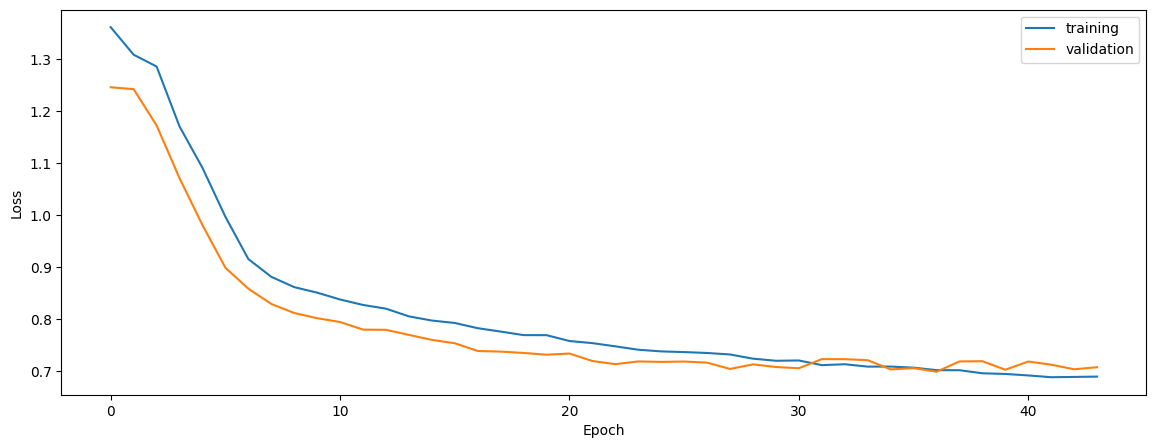

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.7170811468552741
0.721372095524957
0.7115309105187383


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.7170811468552741
0.721372095524957
0.7115309105187383


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.7131081884189039
0.7127296732313786
0.7112942960015161


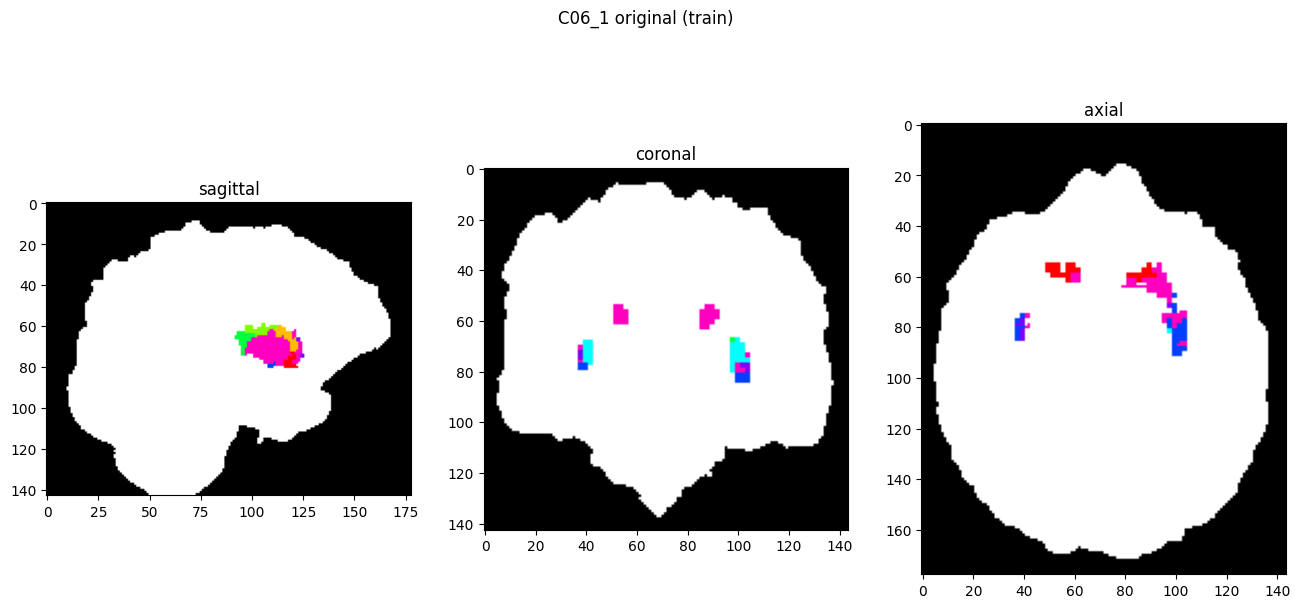

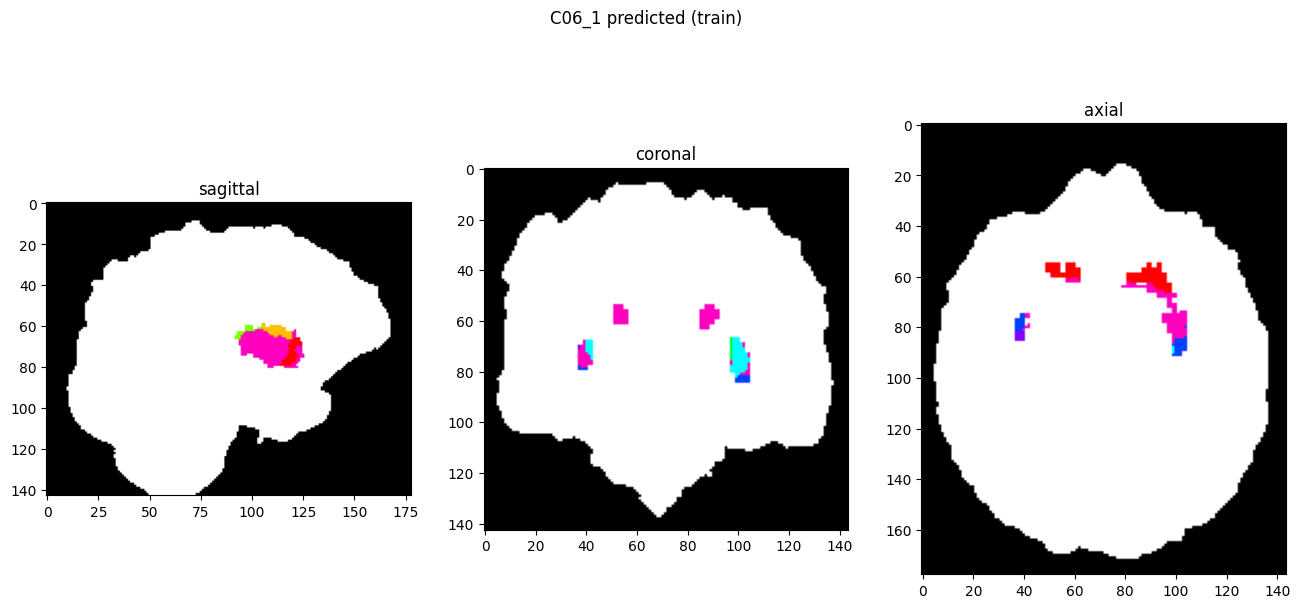

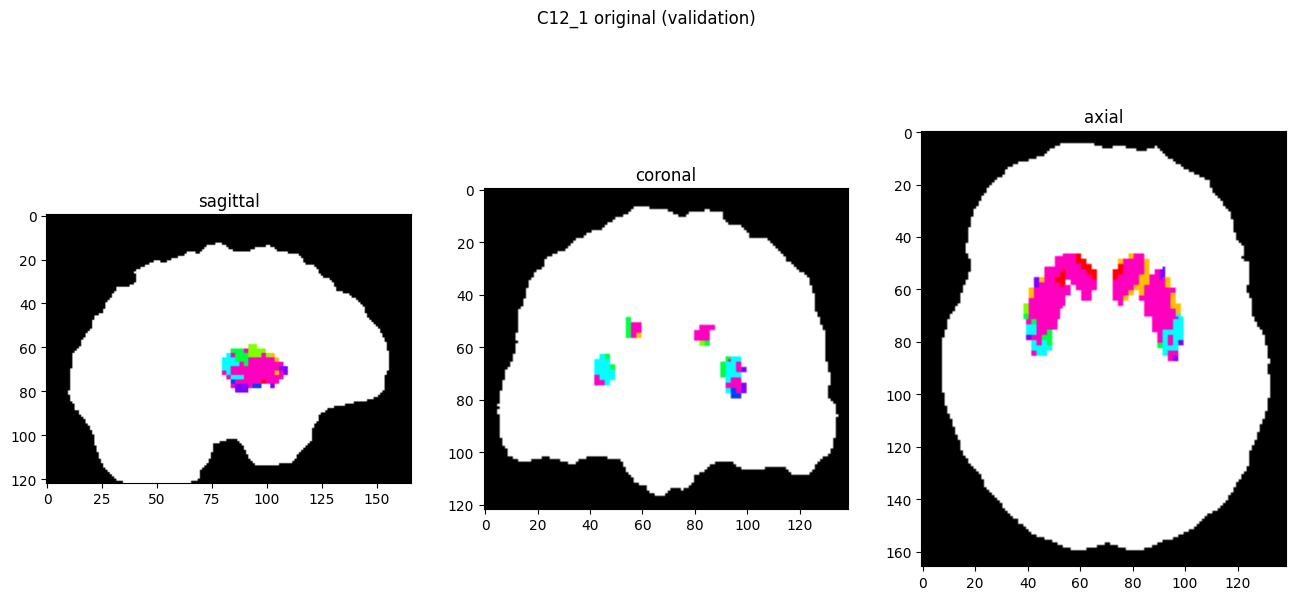

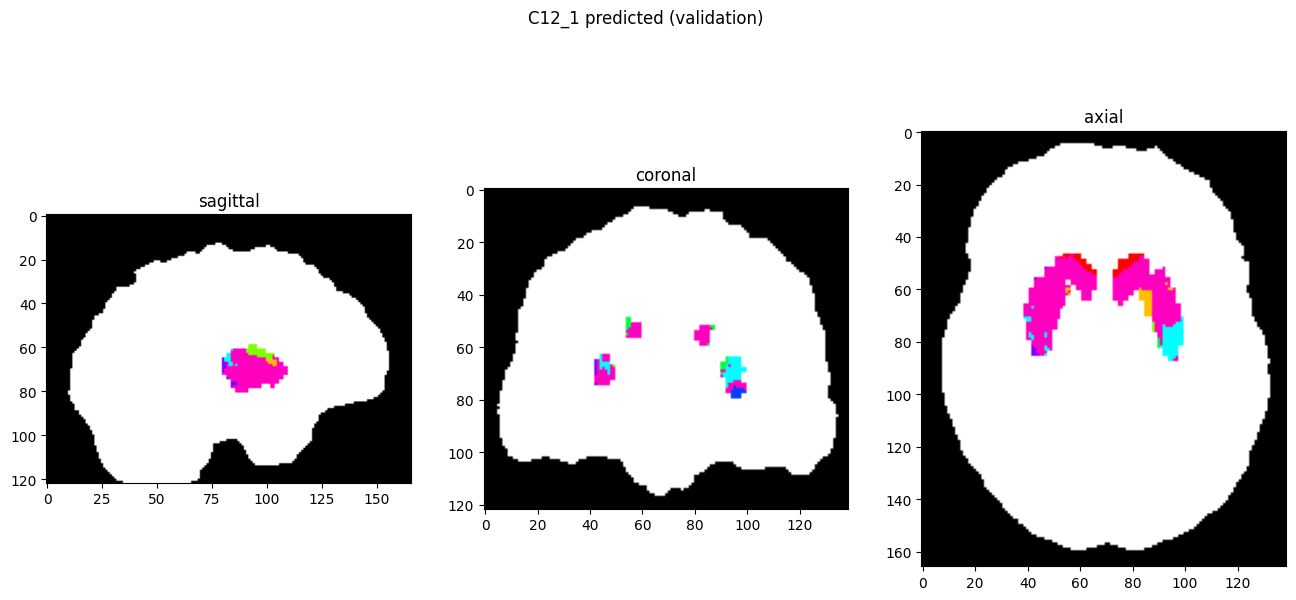

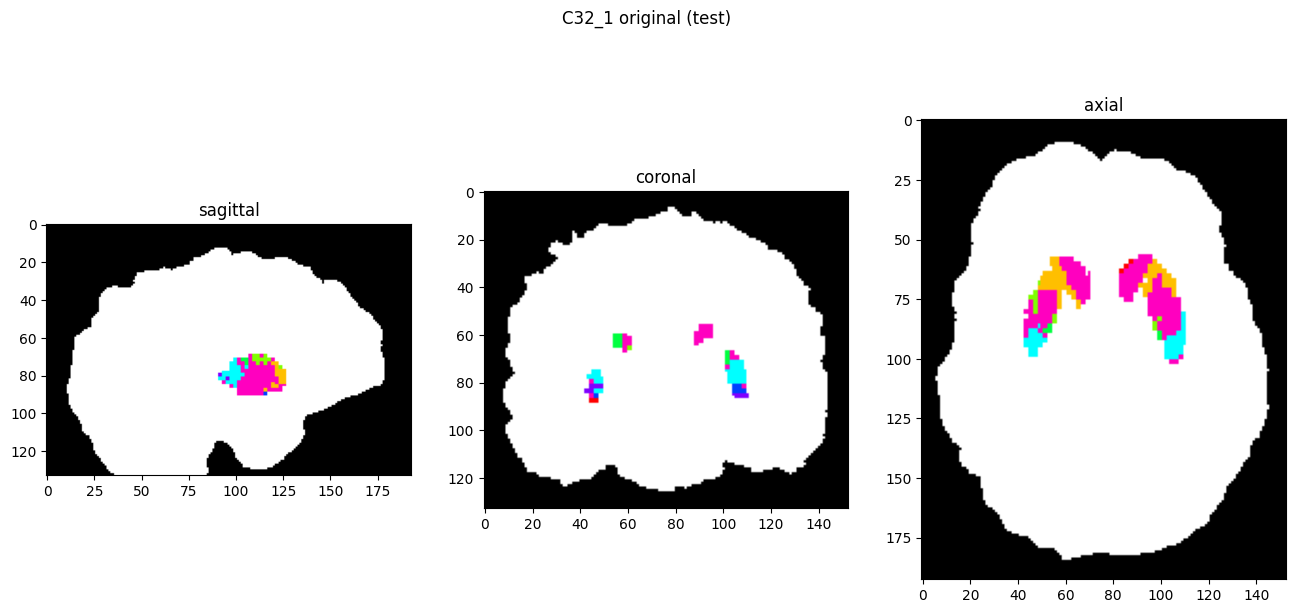

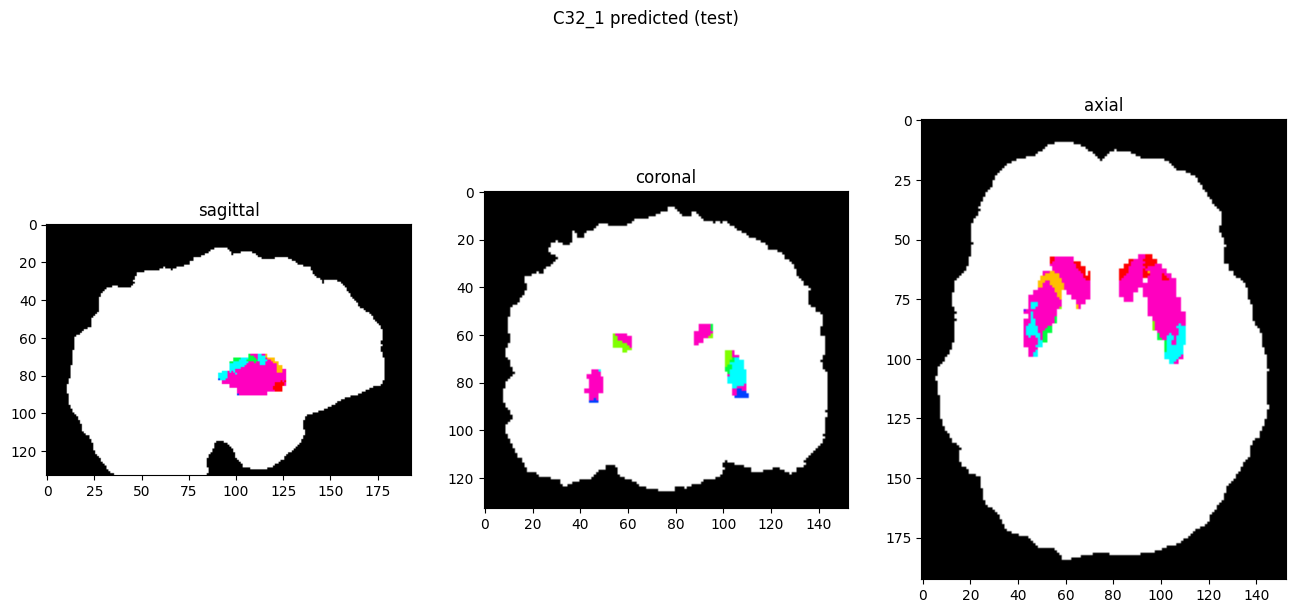

In [10]:
showResults(model, gen, threshold=0)